<a href="https://colab.research.google.com/github/Maurya-Grover/Analyzing-Mobility-and-COVID-19-Spread-in-Indian-States/blob/main/Code/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
population = {
    'Andhra Pradesh' : 53903393,
    'Arunachal Pradesh' : 1570458,
    'Assam' : 35607039,
    'Bihar' : 124799926,
    'Chhattisgarh' : 29436231,
    'Delhi': 18710922,
    'Goa': 1586250,    
    'Gujarat' : 63872399,
    'Haryana': 28204692,
    'Himachal Pradesh': 7451955,
    'Jharkhand': 38593948,
    'Karnataka' : 67562686,
    'Kerala' : 35699443,
    'Madhya Pradesh' : 85358965,
    'Maharashtra' : 123144223,
    'Manipur' : 3091545,
    'Meghalaya': 3366710,
    'Mizoram': 1239244,
    'Nagaland': 2249695,
    'Odisha' : 46356334,
    'Punjab': 30141373,
    'Rajasthan' : 81032689,
    'Sikkim': 690251,
    'Tamil Nadu' : 77841267,
    'Telangana' : 38510982,
    'Tripura': 4169794,
    'Uttar Pradesh' : 237882725,
    'Uttarakhand': 11250858,
    'West Bengal' : 99609303
}

In [ ]:
def fetch_data():
    df1 = pd.read_csv('/content/drive/MyDrive/Archana Ma\'am Project/data.csv')
    df2 = pd.read_csv('/content/drive/MyDrive/Archana Ma\'am Project/states.csv')
    
    return df1, df2

In [ ]:
def preprocessing(df_mobility, df_states):

    # processing mobility data
    columns = df_mobility.columns.values.tolist()
    removal = ['country_region', 'country_region_code','metro_area','iso_3166_2_code','census_fips_code','place_id']
    df_mobility = df_mobility[[x for x in columns if x not in removal]]
    df_mobility = df_mobility[df_mobility['sub_region_2'].isna()]
    df_mobility = df_mobility[df_mobility['sub_region_1'].notna()]
    df_mobility = df_mobility.drop('sub_region_2', axis = 1)
    df_mobility.reset_index(inplace = True, drop = True)

    # renaming column headers for convenience
    df_mobility = df_mobility.rename(columns={"sub_region_1" : 'State', 
                                              'date' : 'Date', 
                                              'retail_and_recreation_percent_change_from_baseline': 'Retail and Recreation',
                                              'grocery_and_pharmacy_percent_change_from_baseline' : 'Grocery and Pharmacy',
                                              'parks_percent_change_from_baseline' : 'Parks',
                                              'transit_stations_percent_change_from_baseline' : 'Transit Stations',
                                              'workplaces_percent_change_from_baseline' : 'Workplaces',
                                              'residential_percent_change_from_baseline' : 'Residential',
                                              })
    df_mobility["Date"] = pd.to_datetime(df_mobility["Date"], dayfirst=True, format='%d-%m-%Y')
    df_mobility = df_mobility.set_index(['State', 'Date'])
      

    # processing states' covid data
    df_states = df_states.sort_values(by=['State','Date'], axis = 0)
    df_states.reset_index(inplace = True, drop = True)
    columns_titles = ['State', 'Date', 'Confirmed', 'Recovered', 'Deceased', 'Other', 'Tested']
    df_states = df_states.reindex(columns=columns_titles)
    df_states["Date"] = pd.to_datetime(df_states["Date"], dayfirst=True, format='%Y-%m-%d')
    for columns_title in columns_titles:
        if columns_title not in ['Date','State']:
            df_states[columns_title] = df_states[columns_title].astype(float)
    # setting index for Join
    df_states.State= df_states.State.astype(str)
    
    # removing territories
    territories = ['Andaman and Nicobar Islands','Chandigarh', 'Jammu and Kashmir', 'Lakshadweep', 'Puducherry']
    for territory in territories:
        df_states = df_states[df_states.State != territory]    
    # removing north-eastern sister states
    # removal = ['Sikkim', 'Tripura', 'Arunachal Pradesh','Nagaland','Assam','Meghalaya','Manipur','Mizoram']
    # consideration = ['Andhra Pradesh', 'Bihar', 'Delhi', 'Gujarat','Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Odisha', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh', 'West Bengal']
    # df_states = df_states.loc[df_states['State'].isin(consideration)]
    
    # setting index for Join
    df_states = df_states.set_index(['State', 'Date'])
    
    return df_mobility, df_states

In [ ]:
def merging_datasets(dataset1, dataset2):
    df_dataset = dataset1.join(dataset2, how='inner')
    df_dataset = df_dataset.reset_index()
    df_dataset = df_dataset[['State', 'Date', 'Retail and Recreation','Grocery and Pharmacy', 'Parks', 'Workplaces', 'Confirmed']]
    df_dataset.dropna(inplace=True)
    df_dataset['Purchases'] = 0.7 * df_dataset['Retail and Recreation'] + 0.3 * df_dataset['Grocery and Pharmacy']
    df_dataset = df_dataset.drop('Retail and Recreation',axis=1)
    df_dataset = df_dataset.drop('Grocery and Pharmacy',axis=1)
    df_dataset = df_dataset[['State', 'Date', 'Purchases', 'Parks', 'Workplaces', 'Confirmed',]]    
    df_dataset.to_csv('/content/drive/MyDrive/Archana Ma\'am Project/dataset.csv')
    
    return df_dataset

In [ ]:
def generate_statewise_data(df_data):
    state_list = df_data['State'].unique()
    states = []
    for i in range(len(state_list)):
        states.append(df_data[df_dataset['State'] == state_list[i]])
        states[i].reset_index(inplace=True,drop=True)
        states[i]['Exposure'] = states[i]['Confirmed']  * 5000 / population[states[i].State[0]]
        states[i].drop('Confirmed',axis=1,inplace=True)
    return states

In [ ]:
def make_path(path, state_name):
    dir_path = os.path.join(path, state_name)
    try:
        os.mkdir(dir_path)
    except OSError as error:
        pass
    return dir_path

In [ ]:
def plot_state_data(df):
    fig, ax = plt.subplots(figsize=(25, 15))

    # Plot Purchases
    ax.plot(df.Date, df.Purchases, color='tab:blue', label='Purchases')
    ax.plot(df.Date, df.Parks, color='tab:green', label='Parks')
    ax.plot(df.Date, df.Workplaces, color='tab:orange', label='Workplaces')
    ax.plot(df.Date, df['Exposure'], color='tab:red', label='Exposure(per 5000 individuals)')

    # Set Axes Labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Deviations From Baseline')
    ax.set_title(df.State[0])

    # format x axis labels
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

    ax.legend(loc='upper left',fontsize=25);
    parent_dir = '/content/drive/MyDrive/Archana Ma\'am Project/State Graphs'
    save_dir =  make_path(parent_dir, df.State[0])
    print(save_dir)
    df.to_csv(save_dir + '/dataset.csv')
    save_dir += '/' + df.State[0] + '.jpg'
    print(save_dir)
    plt.savefig(save_dir)
    print(df.State[0] + " File Created")

In [ ]:
df1, df2 = fetch_data()
df_mobility, df_states = preprocessing(df1, df2)
df_dataset = merging_datasets(df_mobility, df_states)
states = generate_statewise_data(df_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Andhra Pradesh
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Andhra Pradesh/Andhra Pradesh.jpg
Andhra Pradesh File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Arunachal Pradesh
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Arunachal Pradesh/Arunachal Pradesh.jpg
Arunachal Pradesh File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Assam
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Assam/Assam.jpg
Assam File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Bihar
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Bihar/Bihar.jpg
Bihar File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Chhattisgarh
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Chhattisgarh/Chhattisgarh.jpg
Chhattisgarh File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Delhi
/content/drive/MyDrive/Archana Ma'am Pr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Punjab File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Rajasthan
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Rajasthan/Rajasthan.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Rajasthan File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Sikkim
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Sikkim/Sikkim.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Sikkim File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Tamil Nadu
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Tamil Nadu/Tamil Nadu.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Tamil Nadu File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Telangana
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Telangana/Telangana.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Telangana File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Tripura
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Tripura/Tripura.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Tripura File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Uttar Pradesh
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Uttar Pradesh/Uttar Pradesh.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Uttar Pradesh File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Uttarakhand
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/Uttarakhand/Uttarakhand.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Uttarakhand File Created
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/West Bengal
/content/drive/MyDrive/Archana Ma'am Project/State Graphs/West Bengal/West Bengal.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


West Bengal File Created


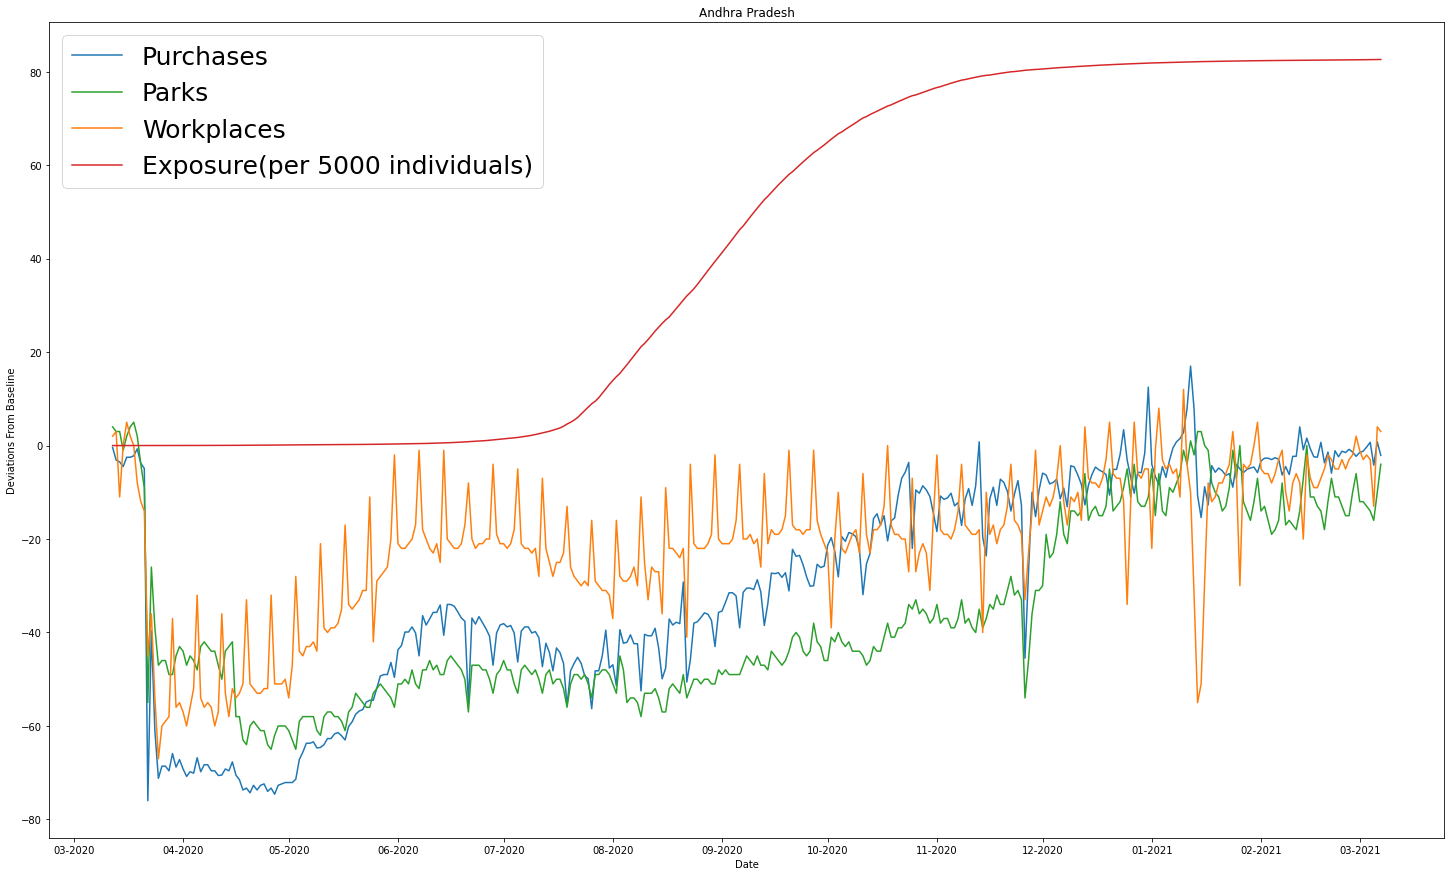

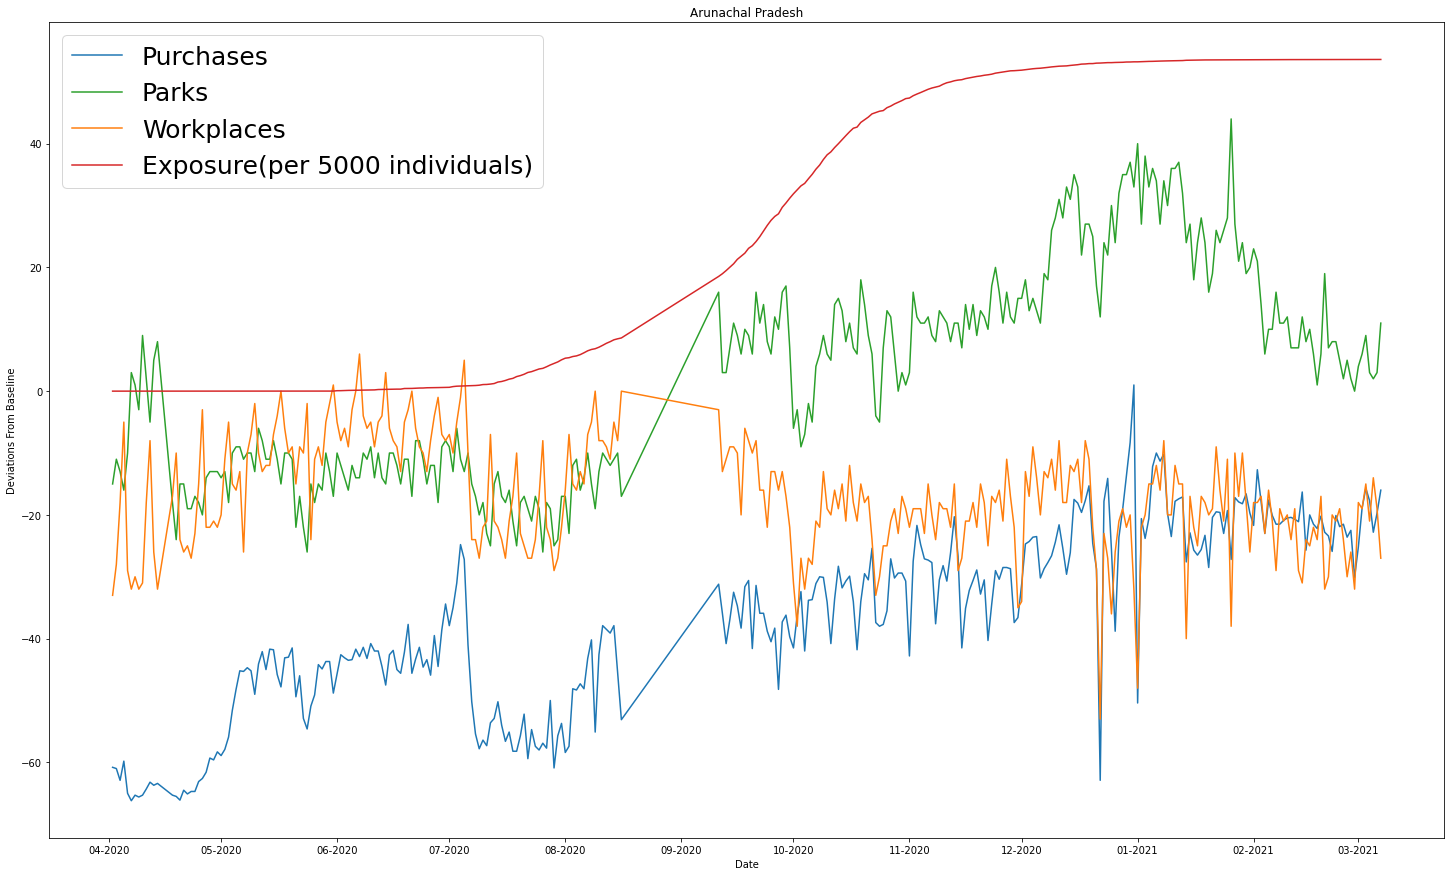

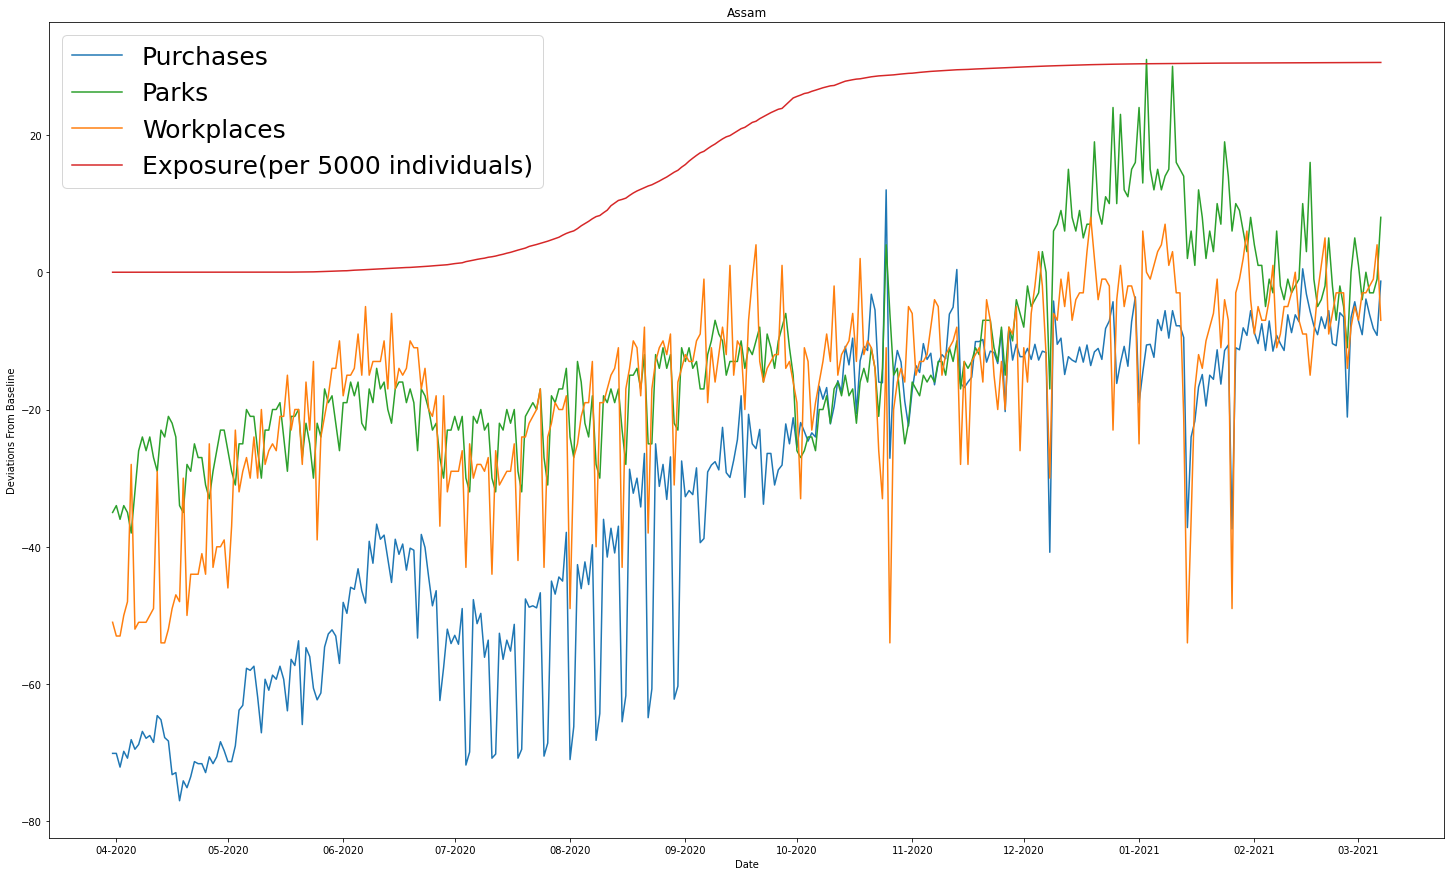

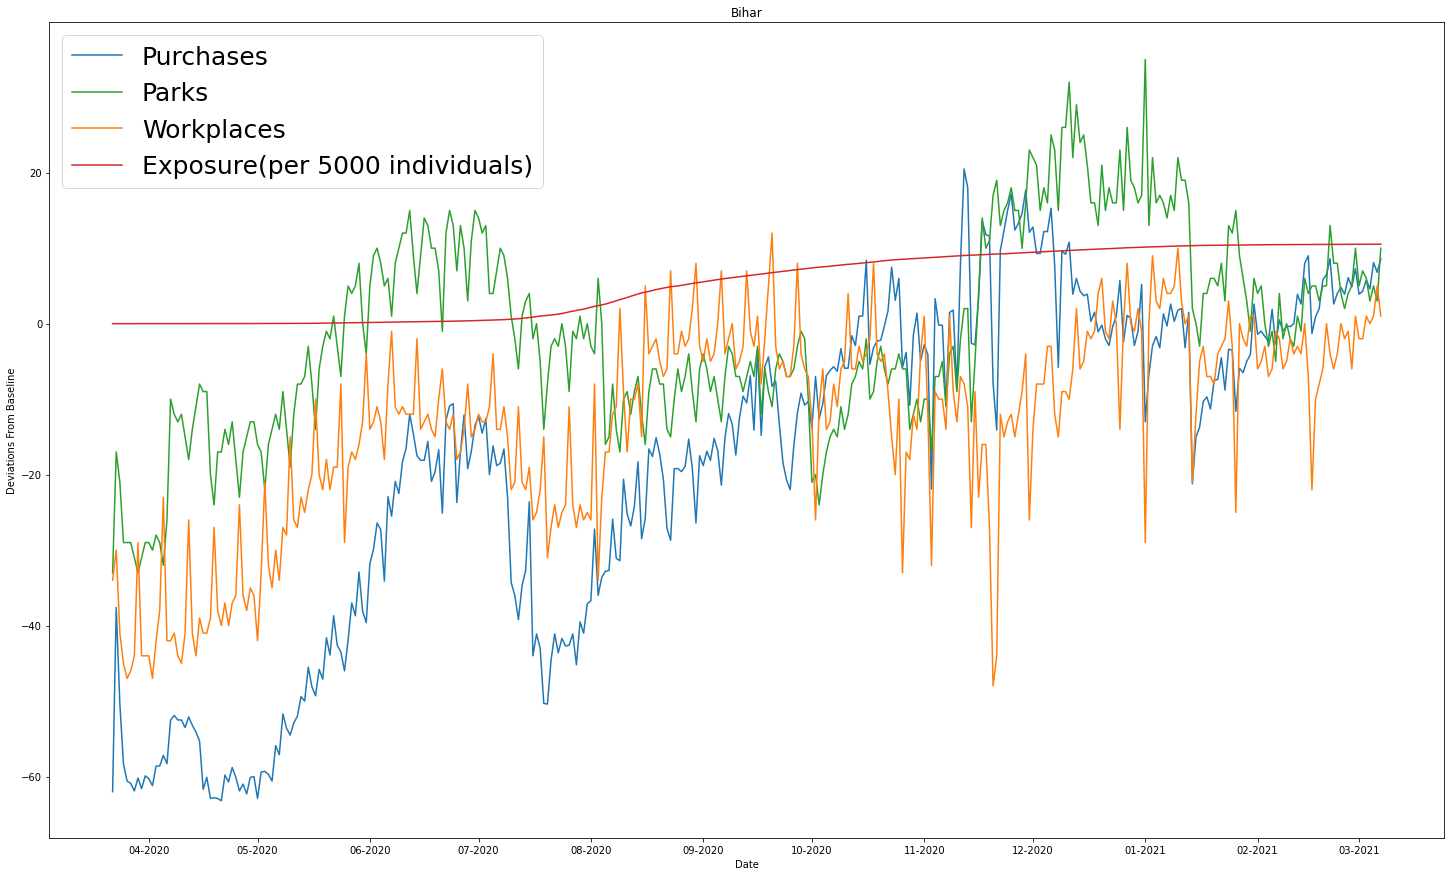

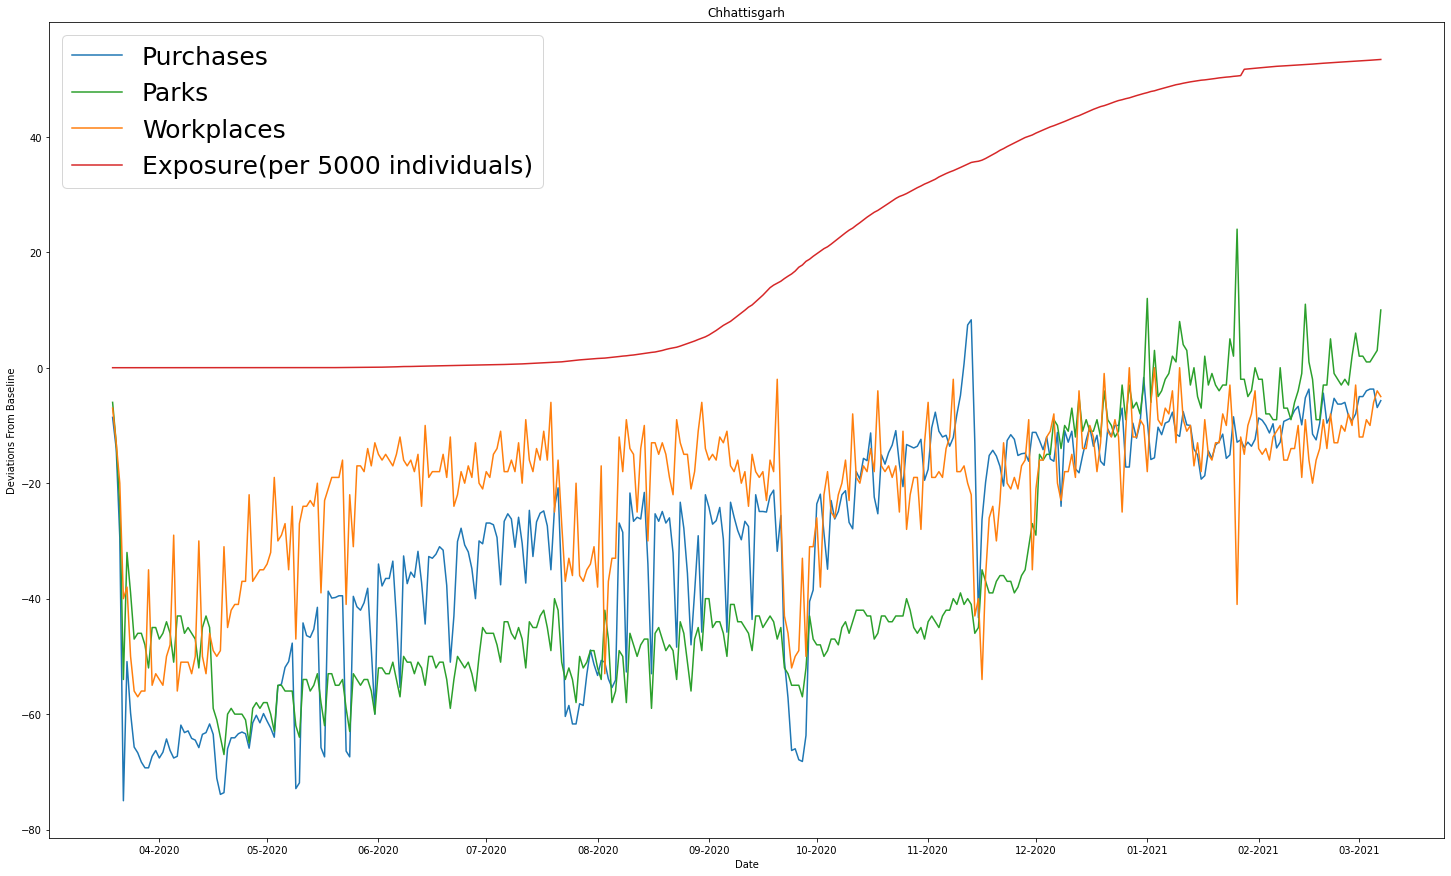

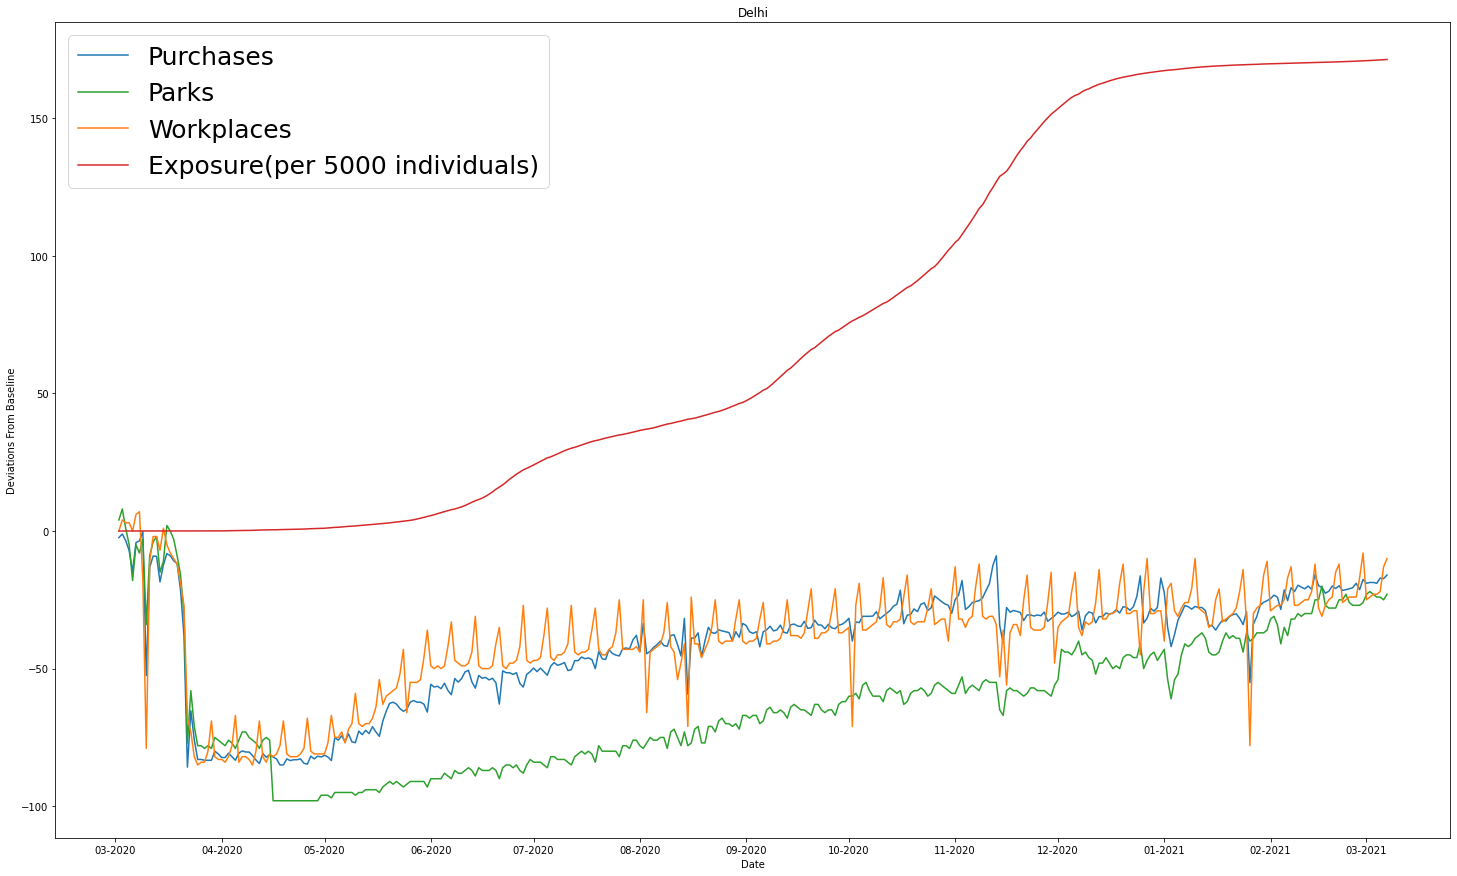

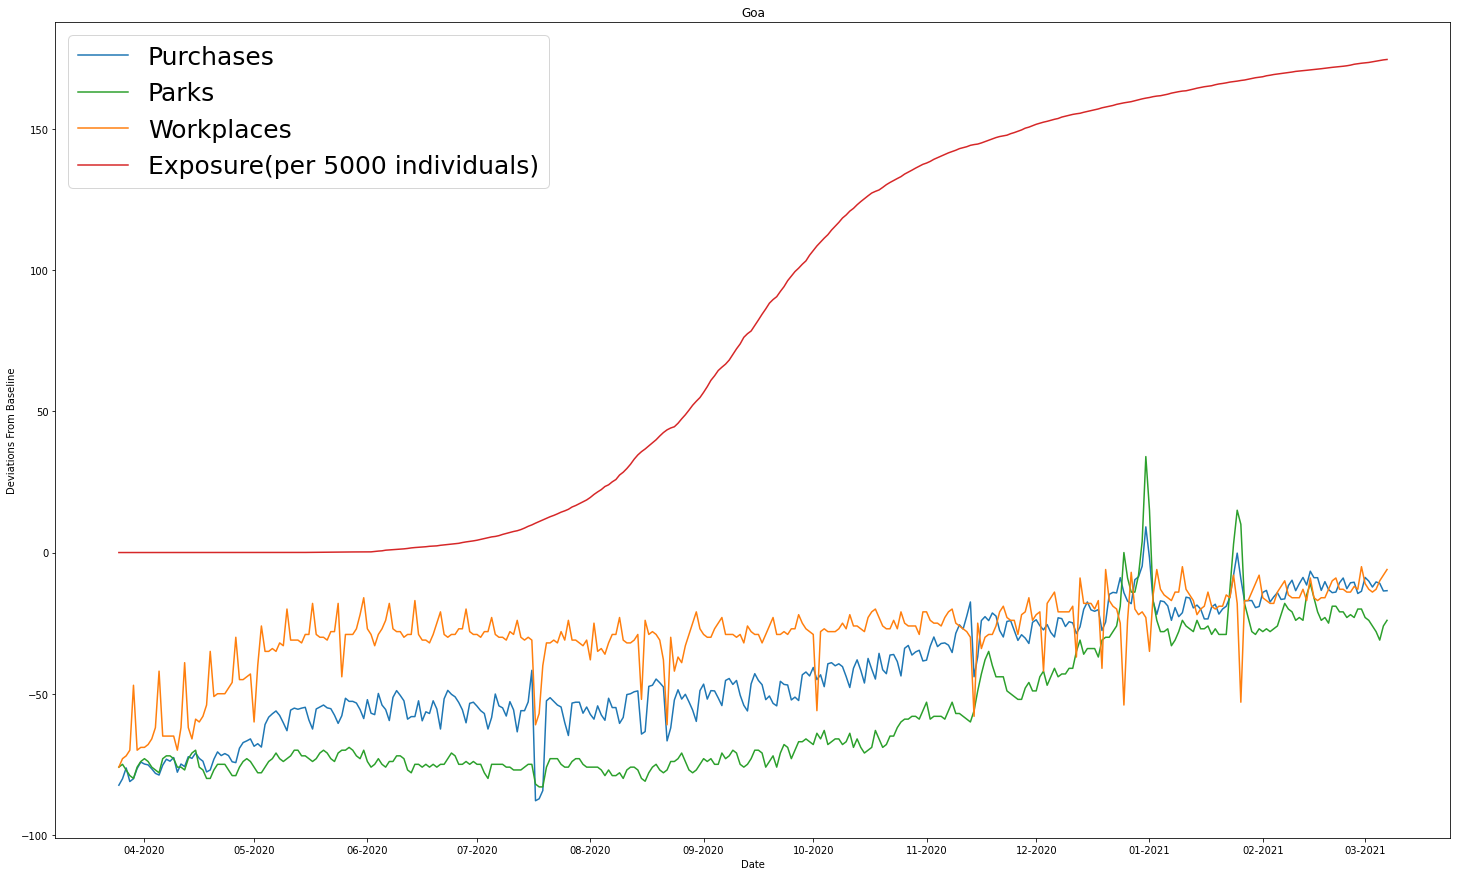

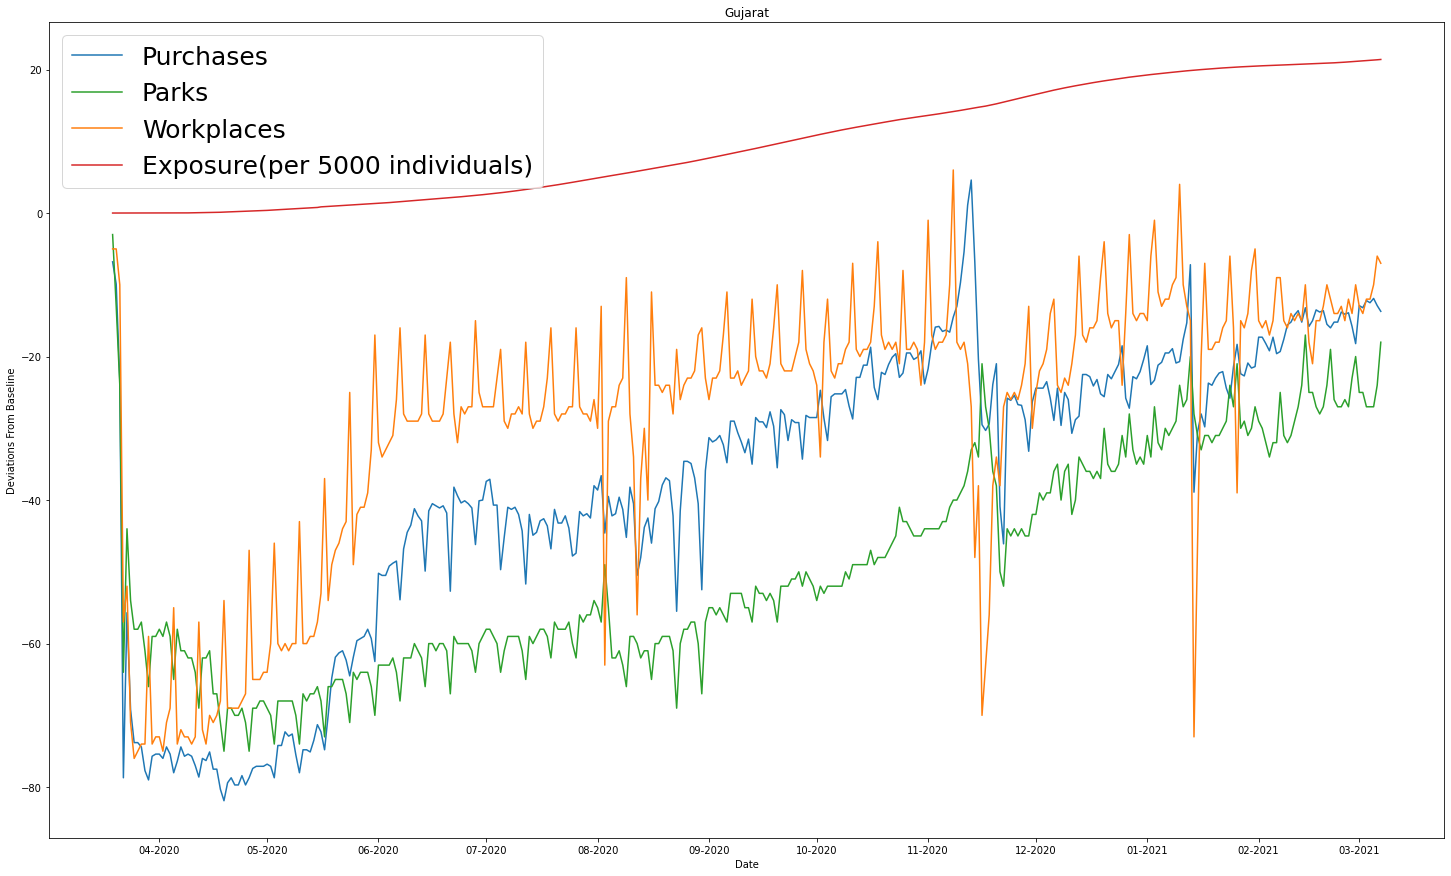

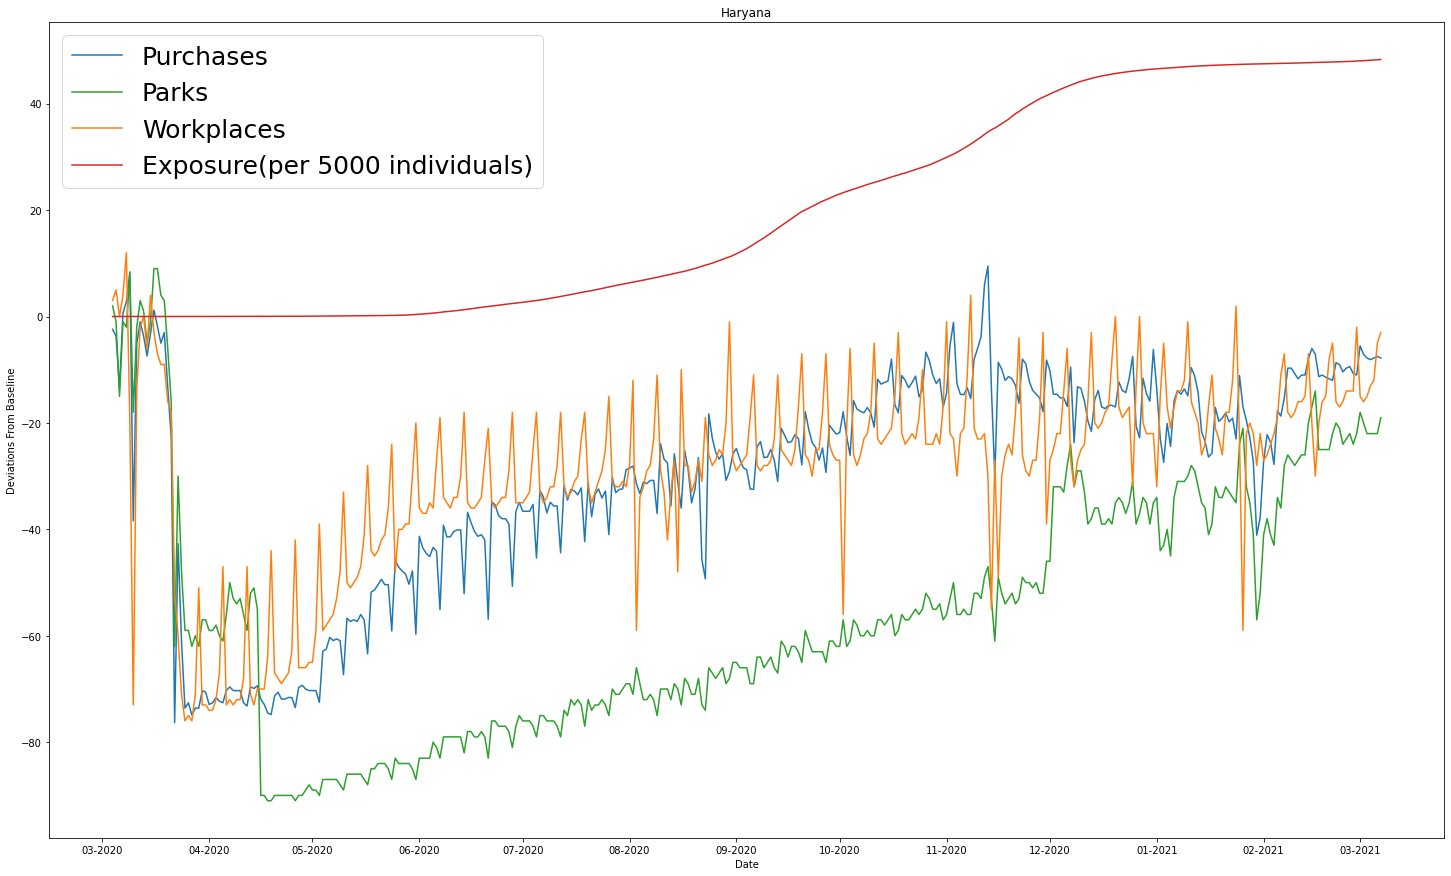

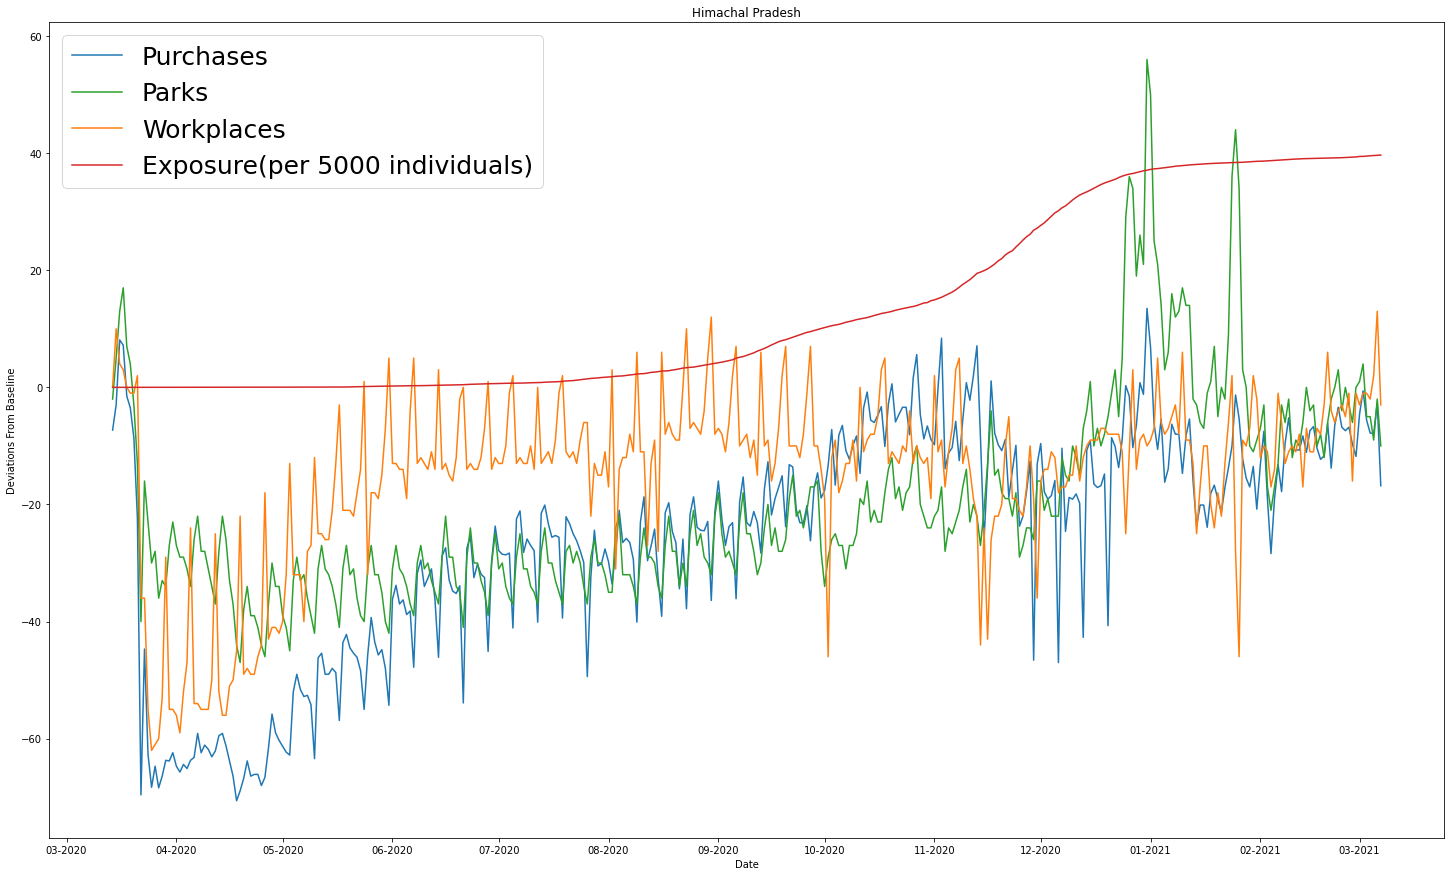

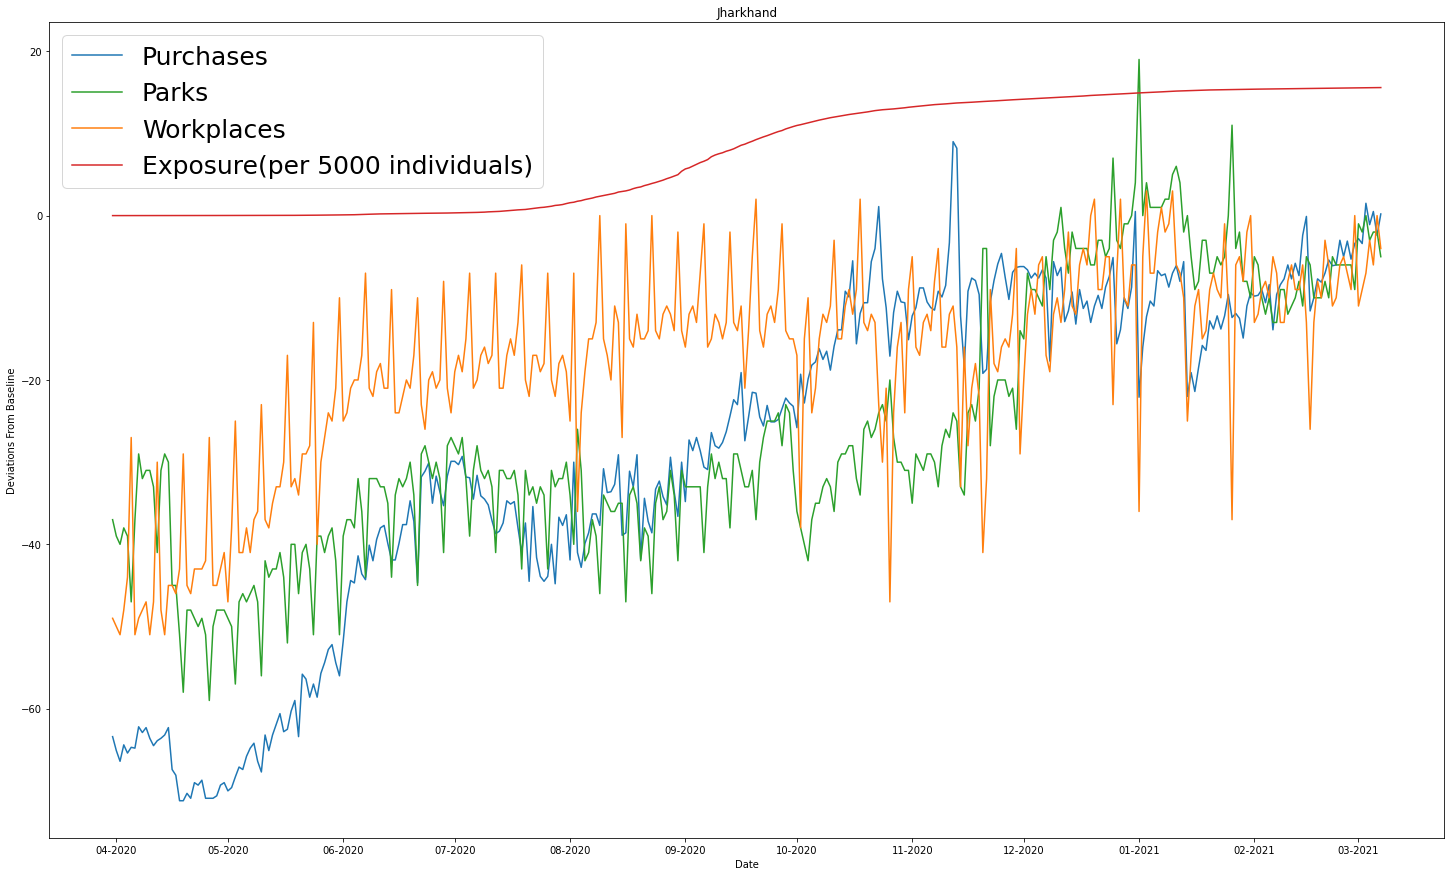

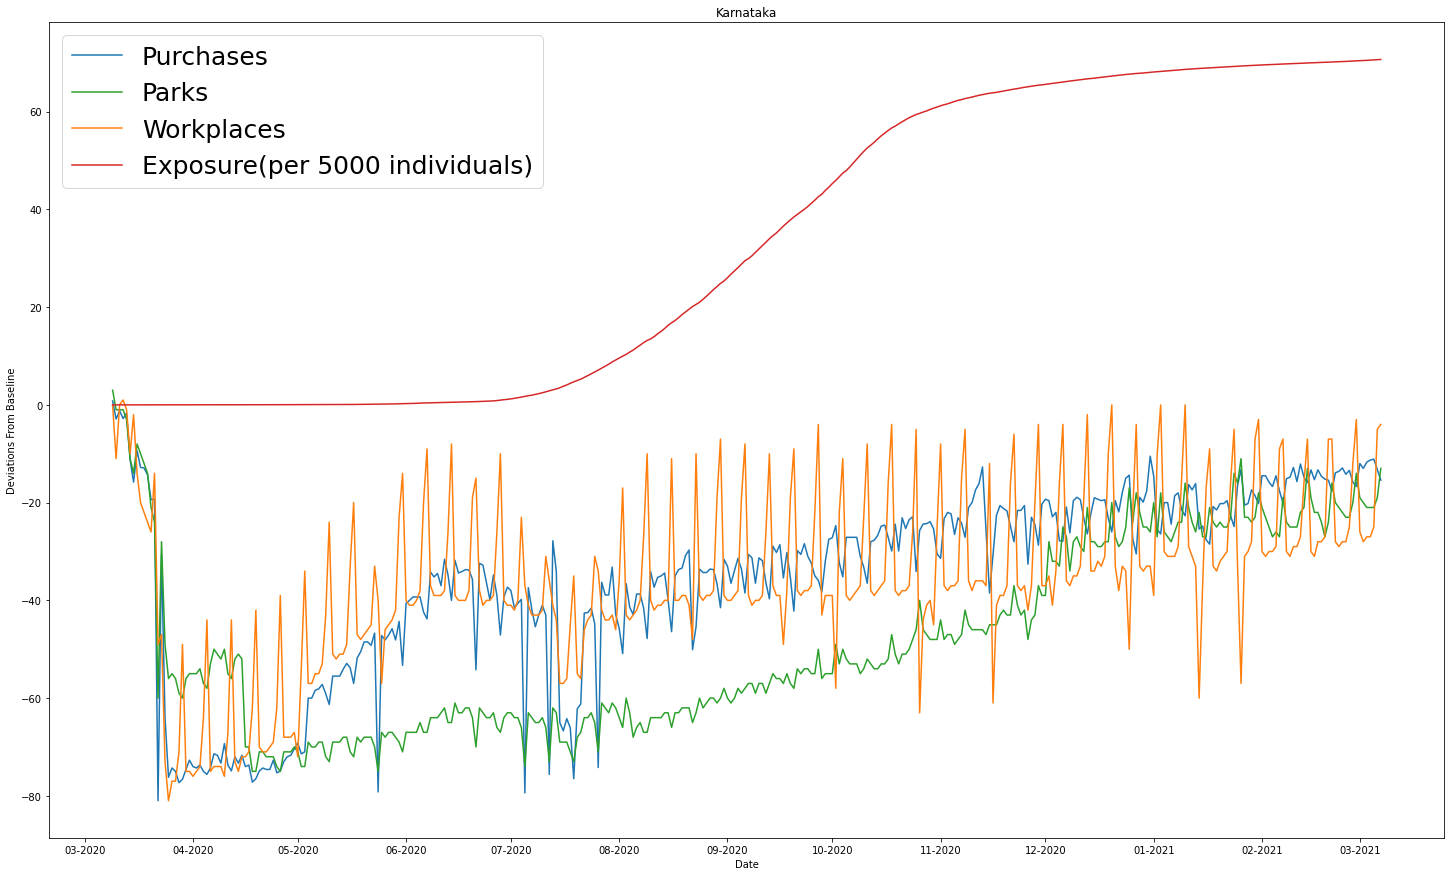

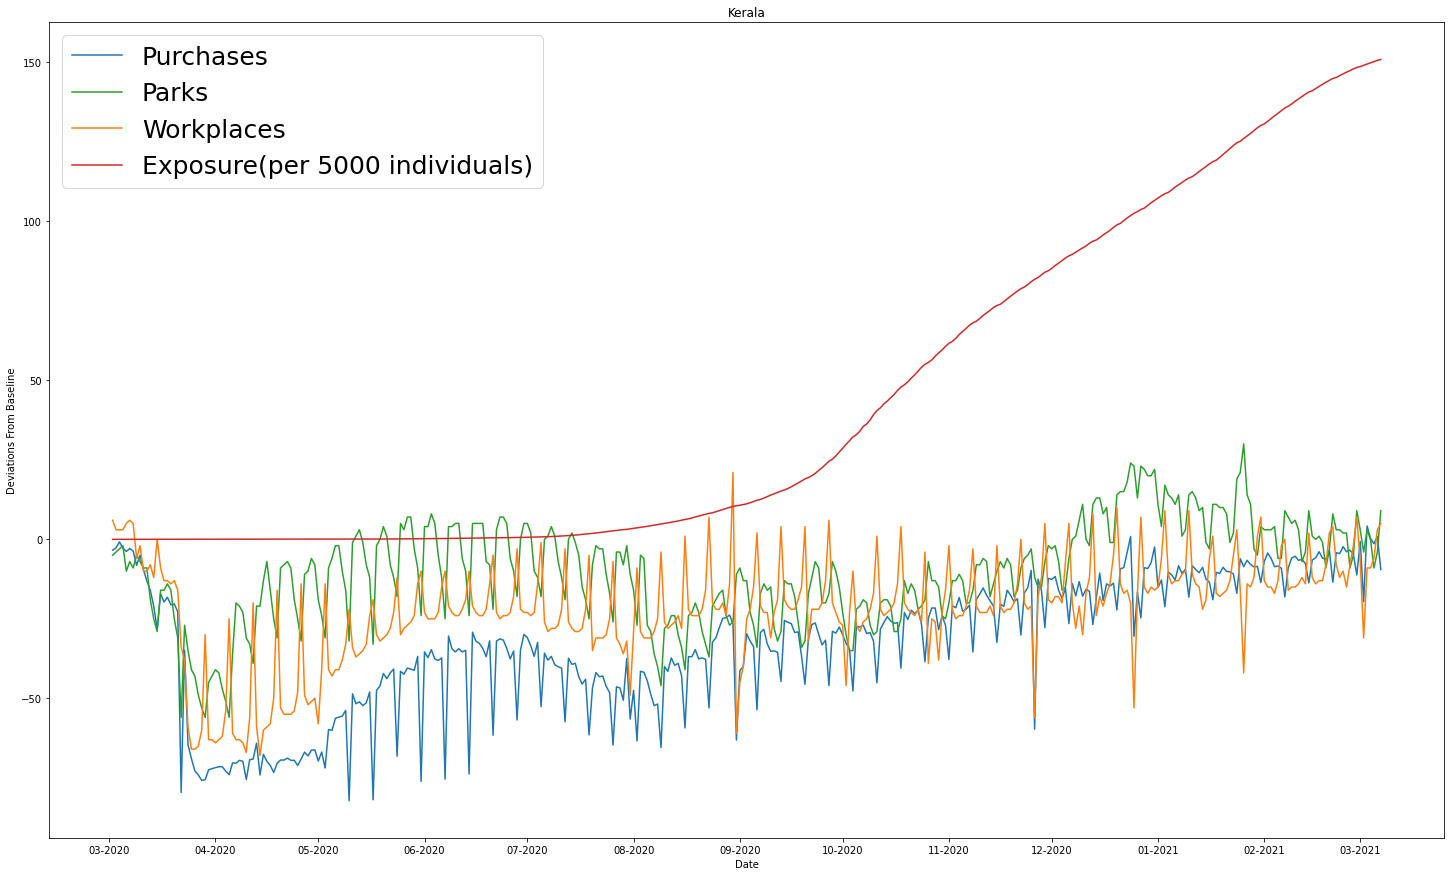

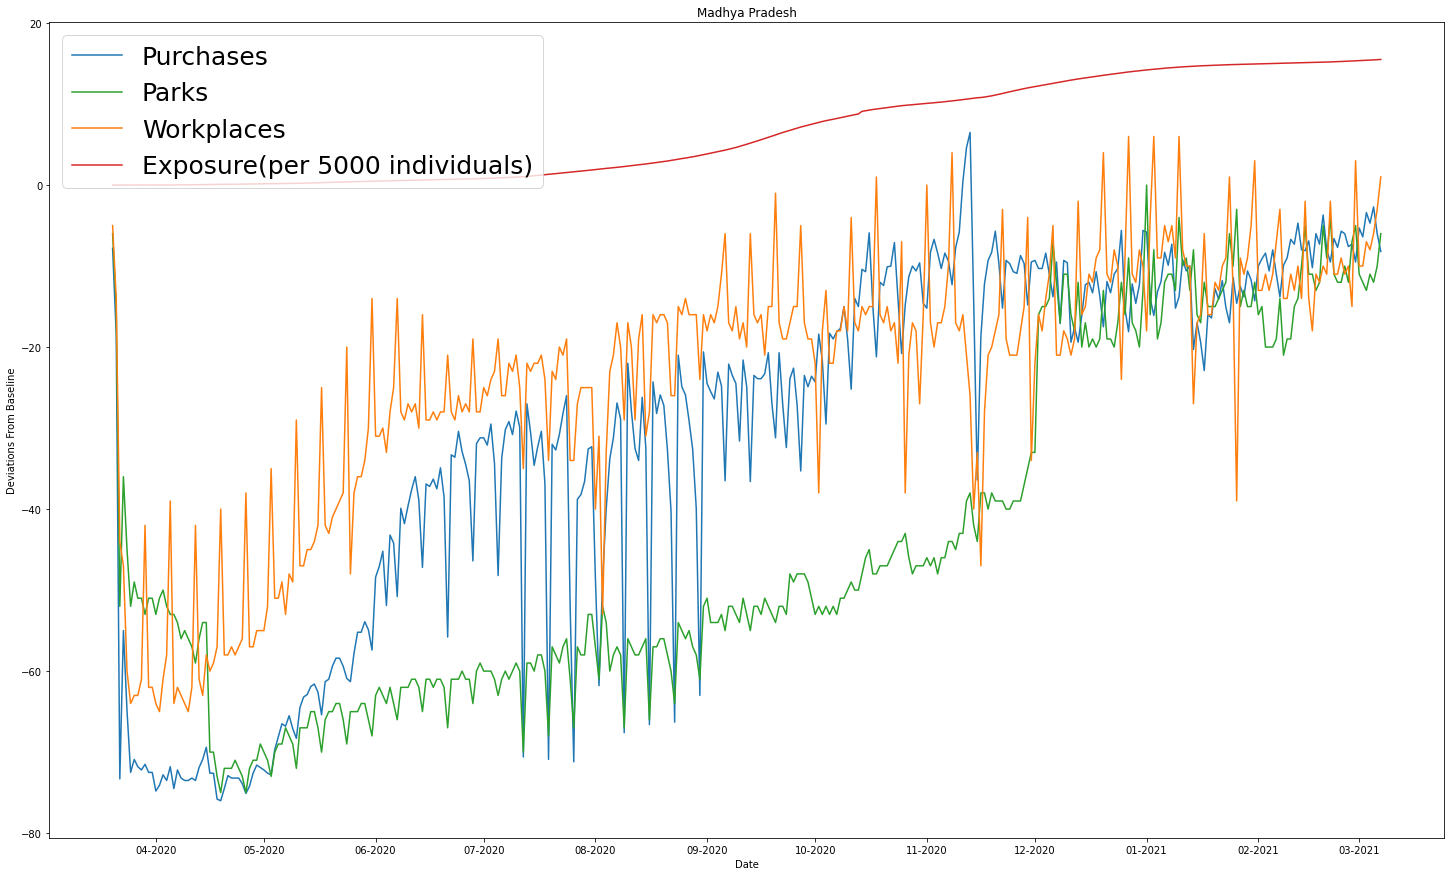

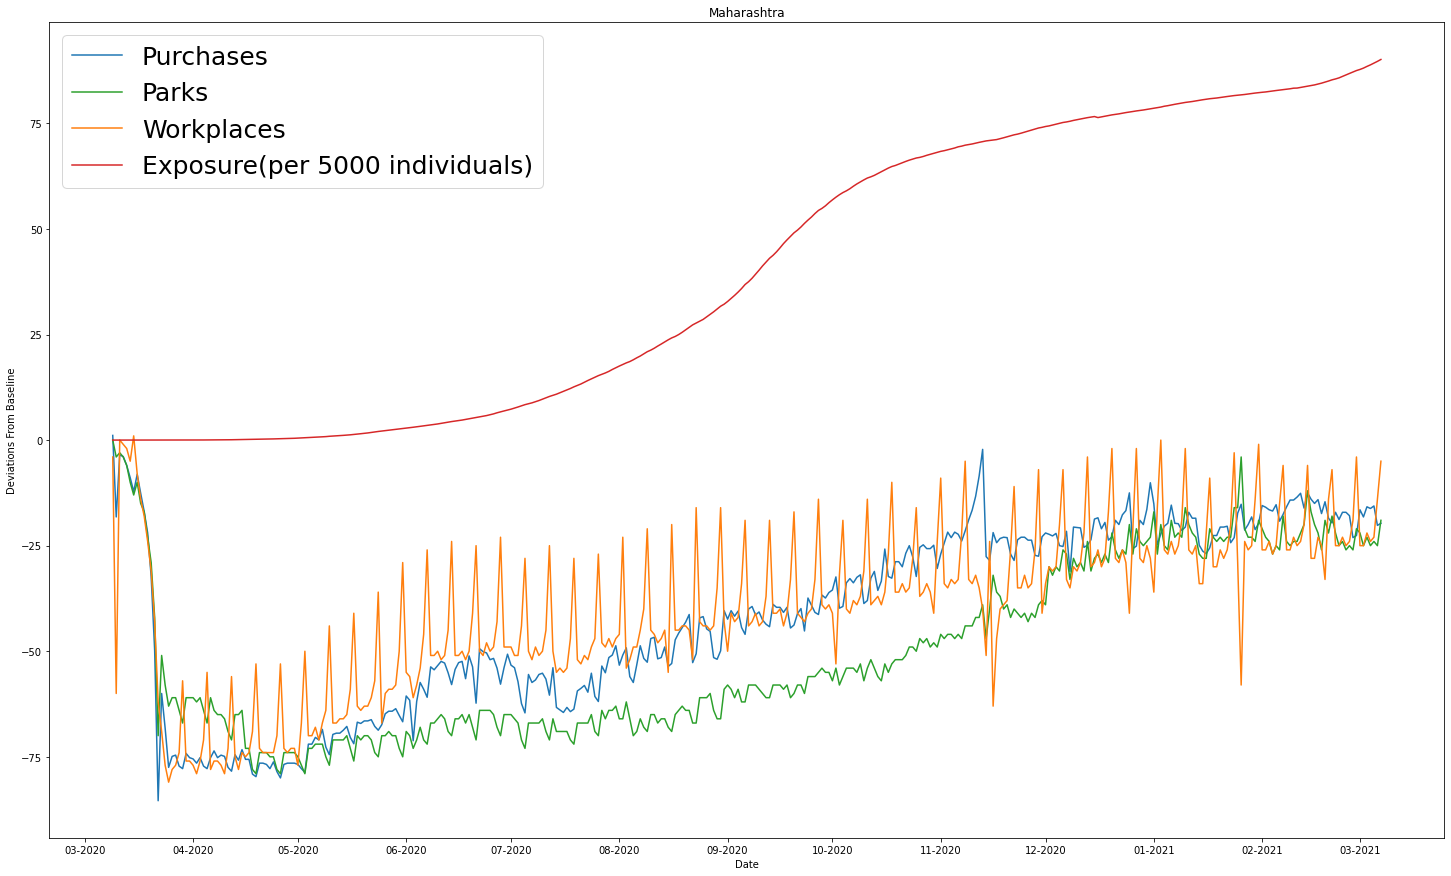

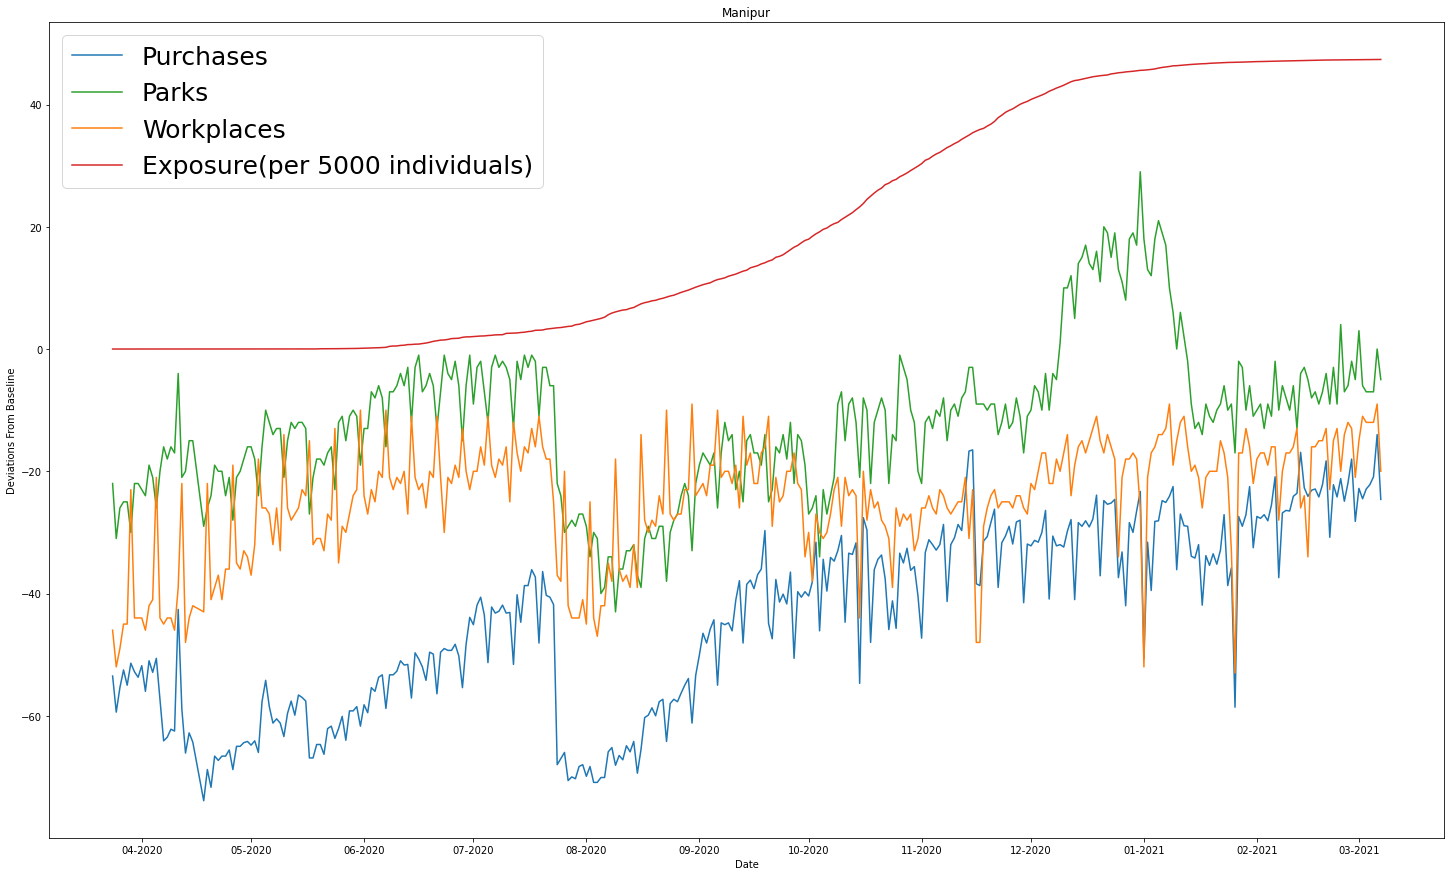

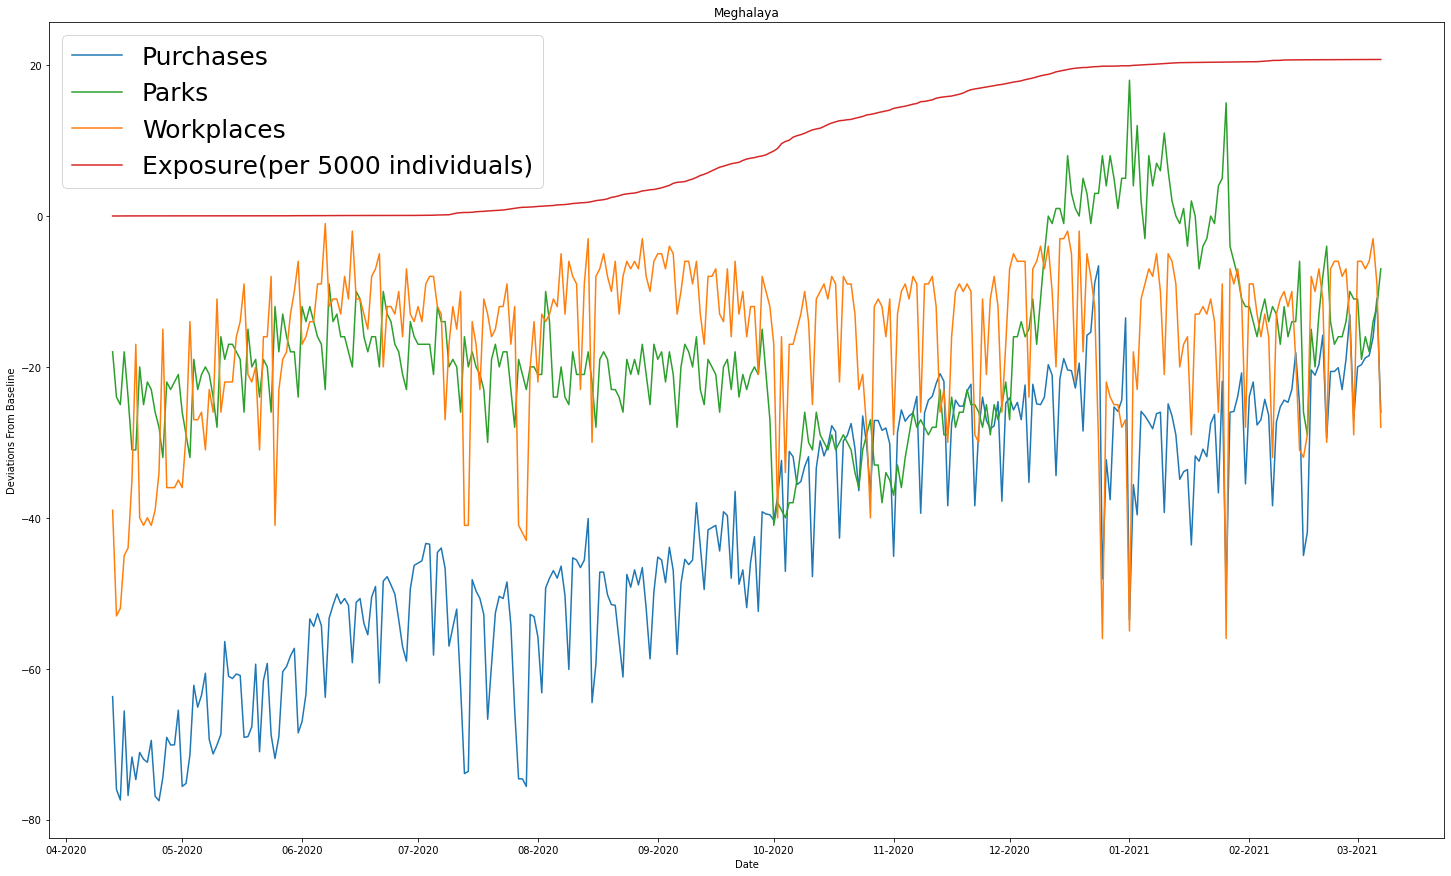

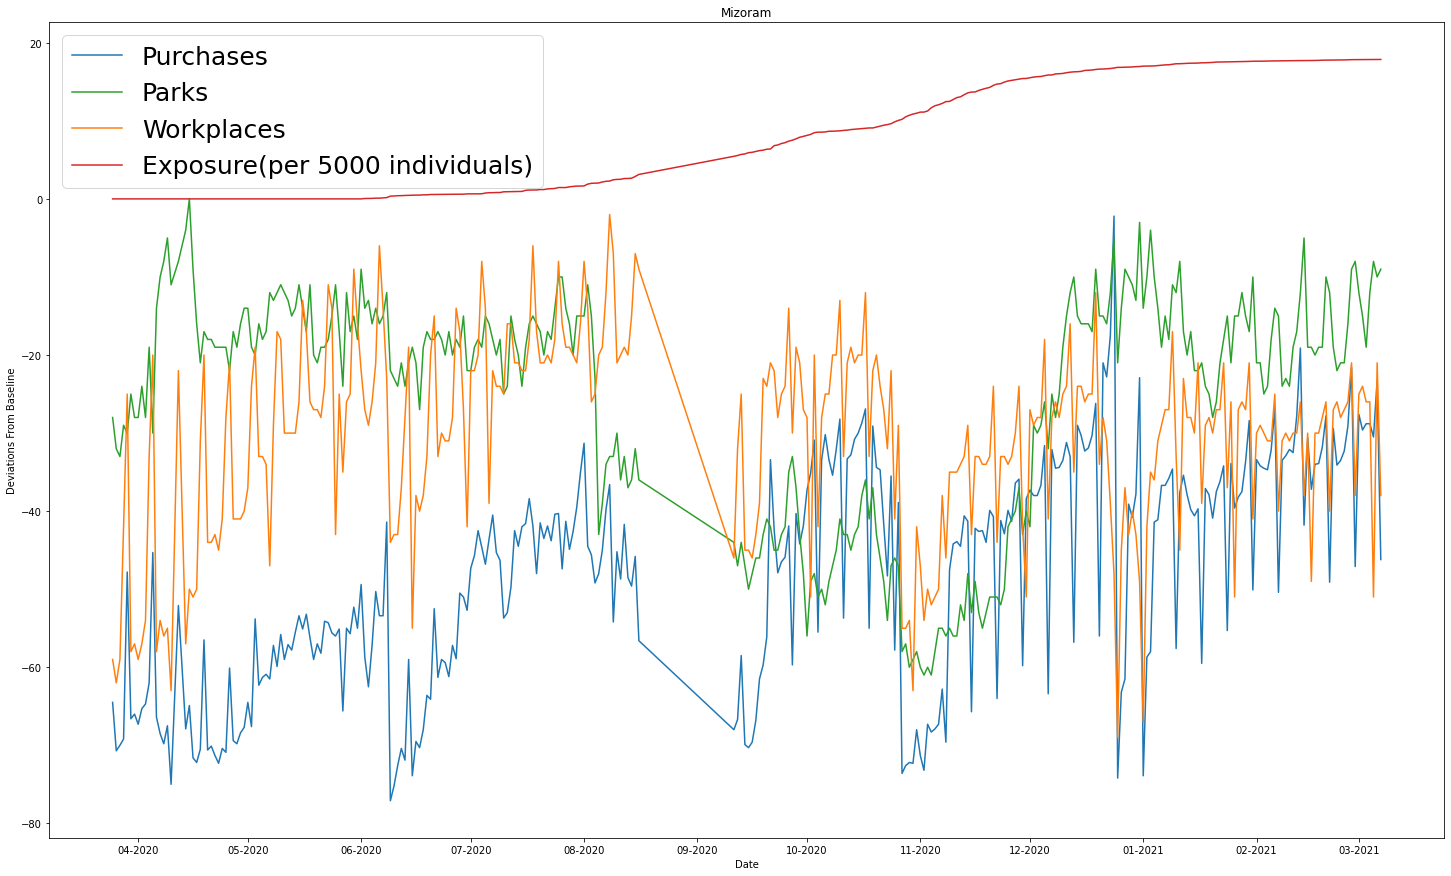

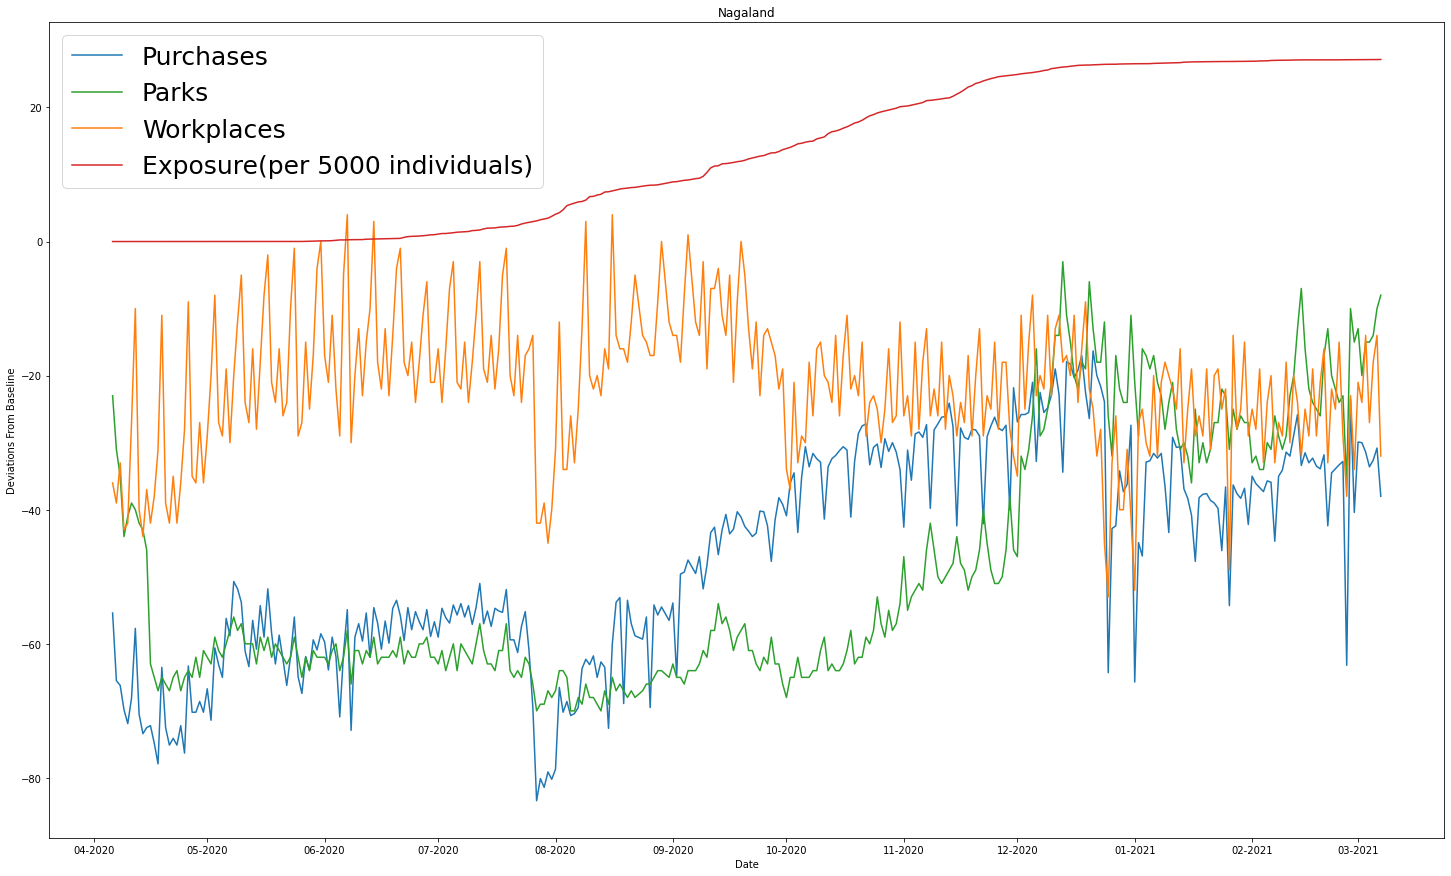

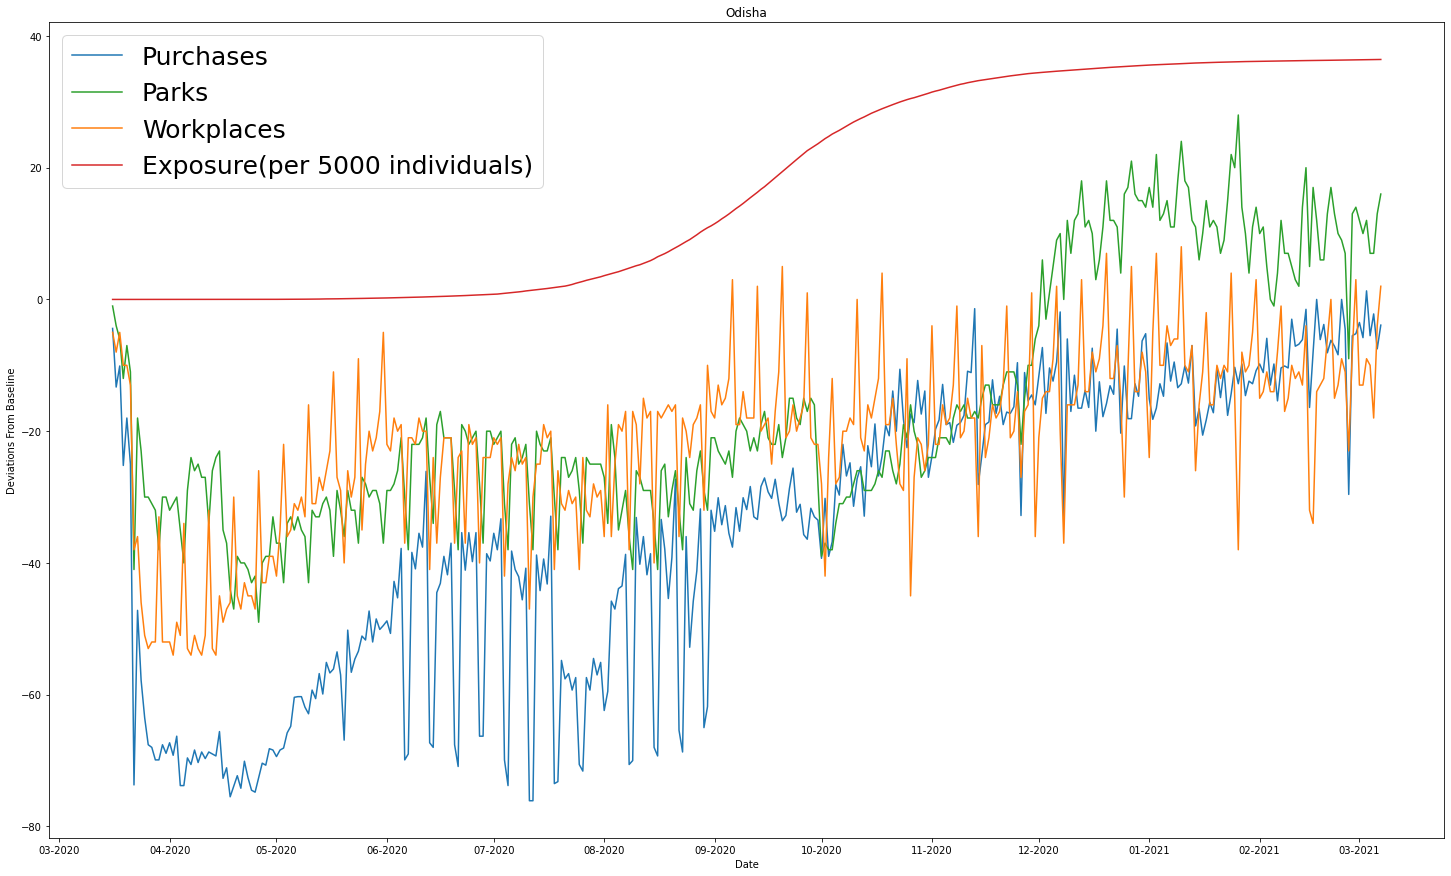

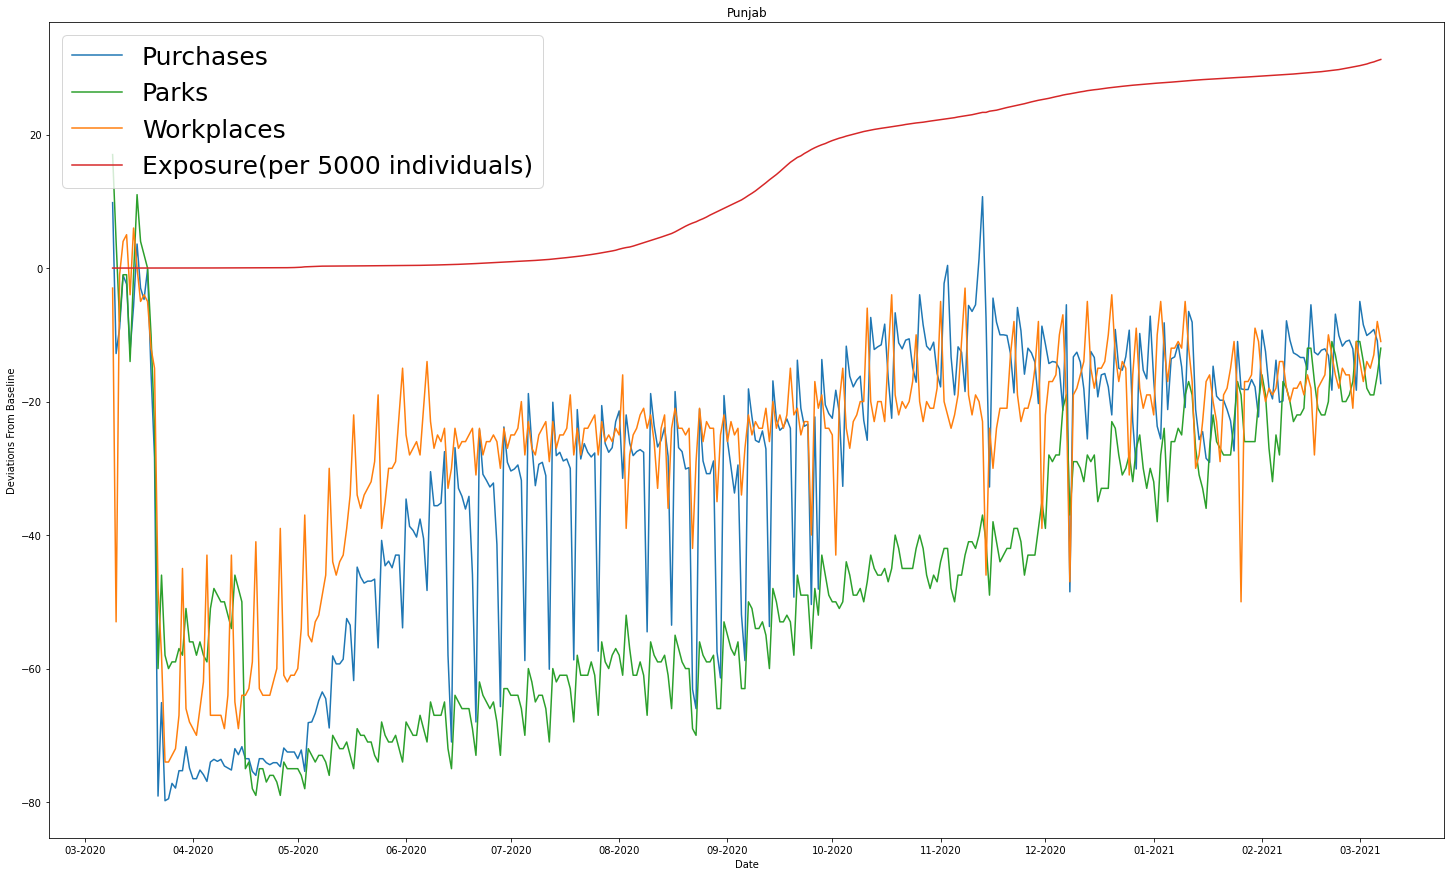

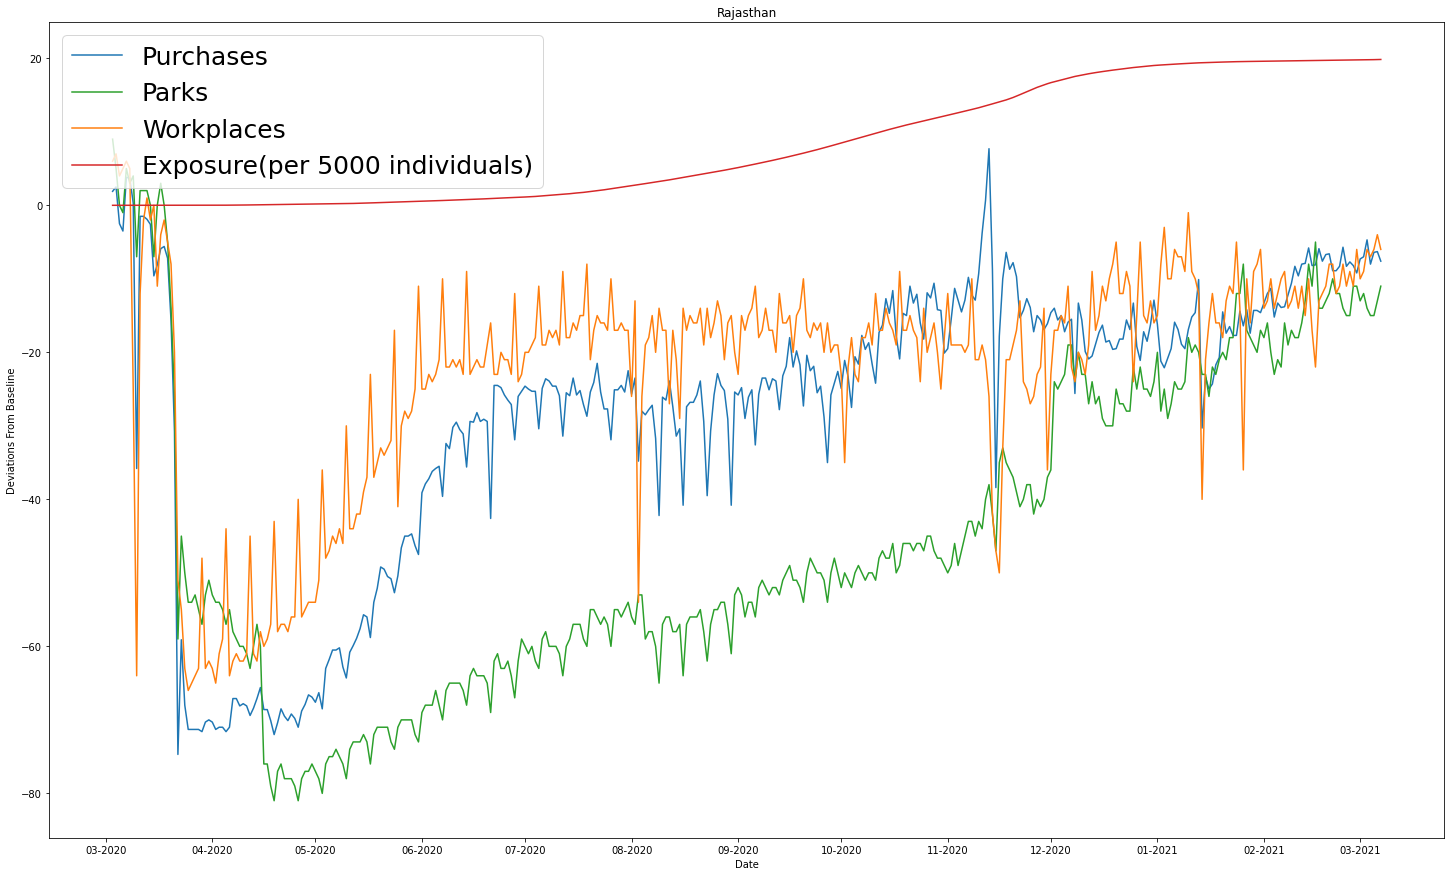

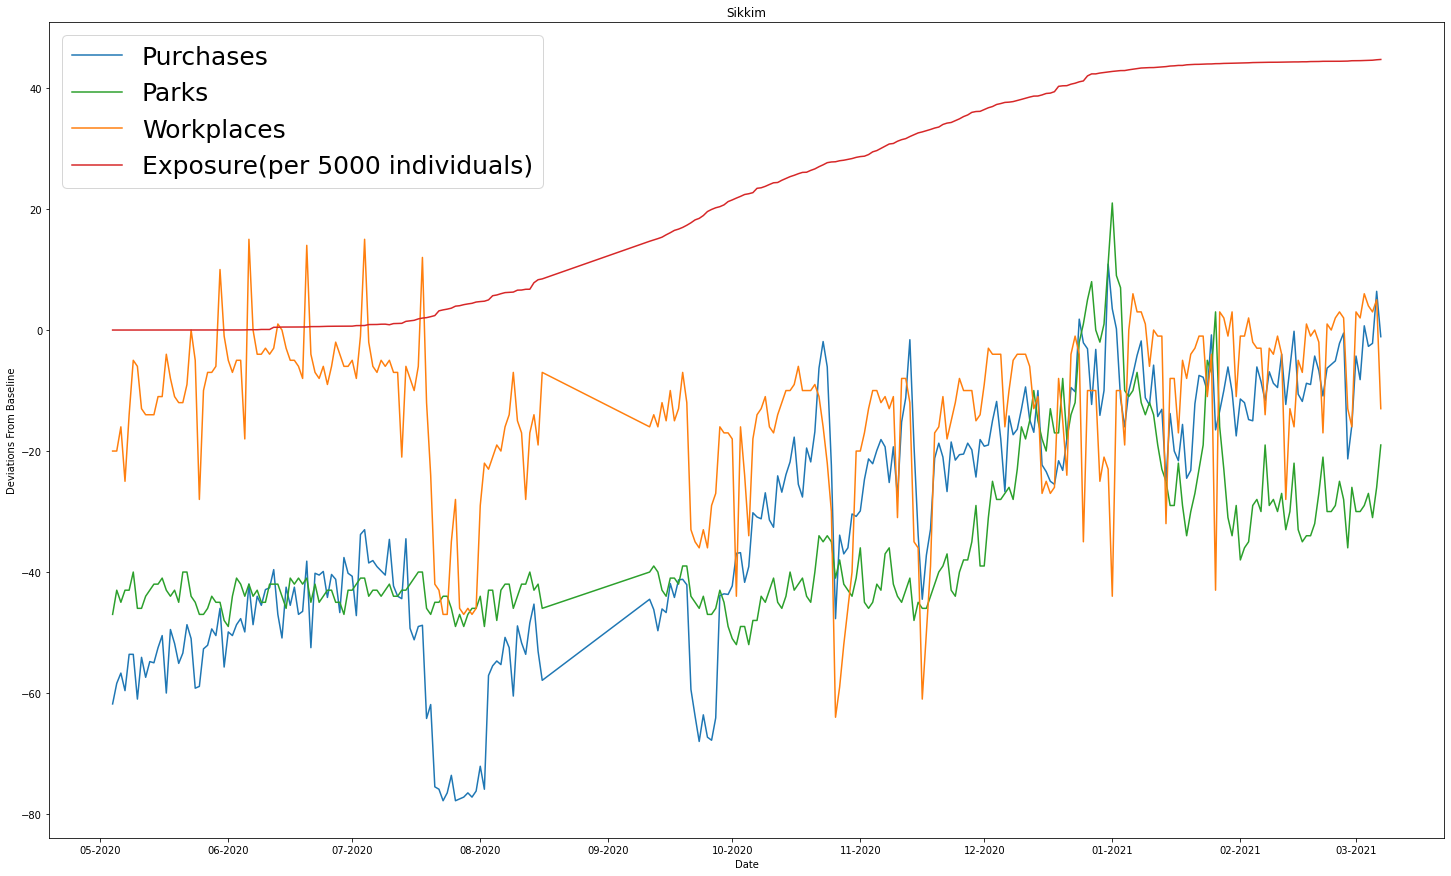

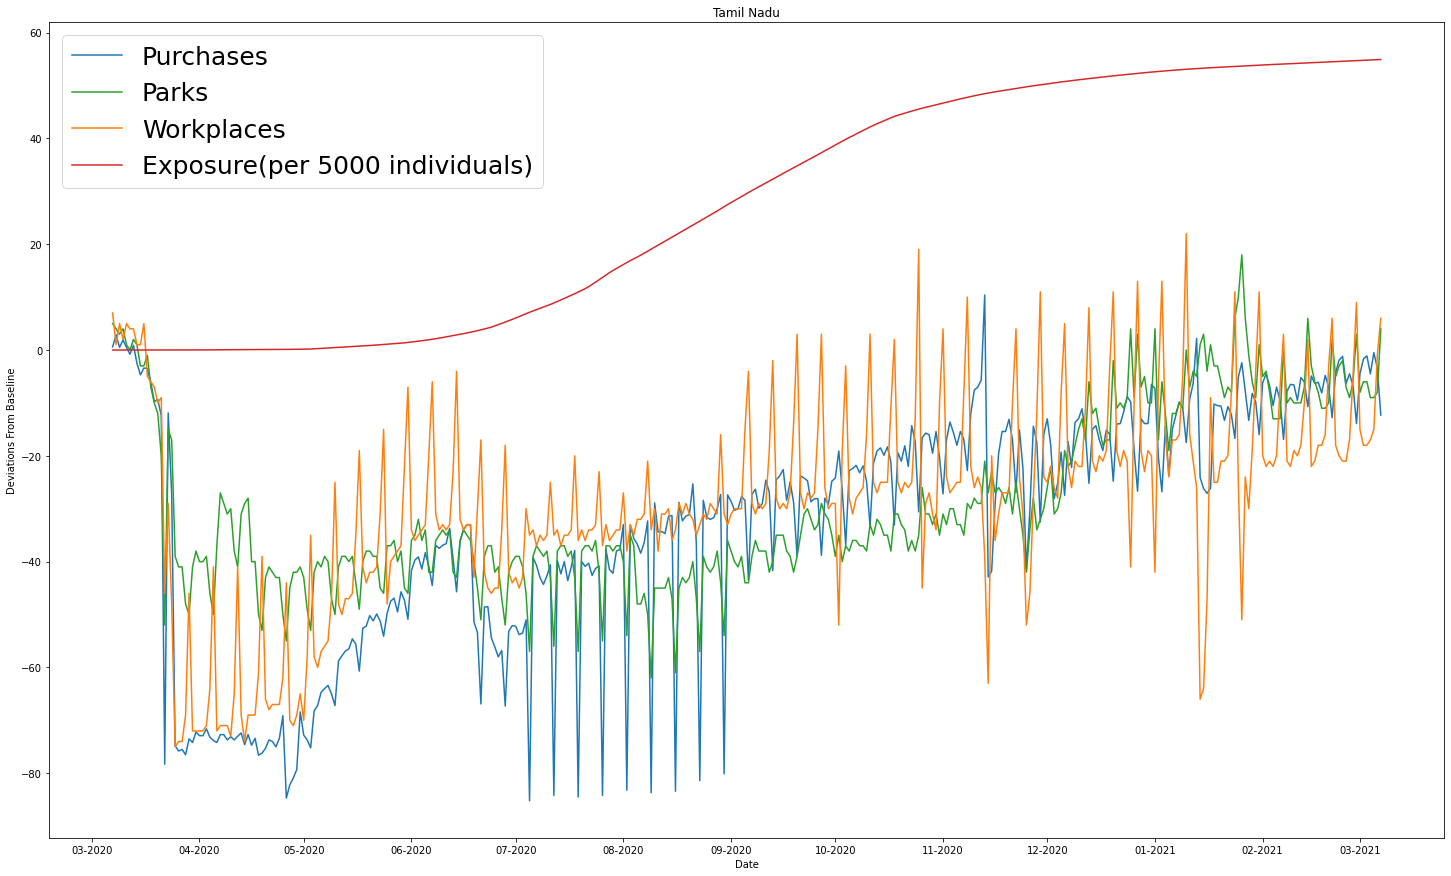

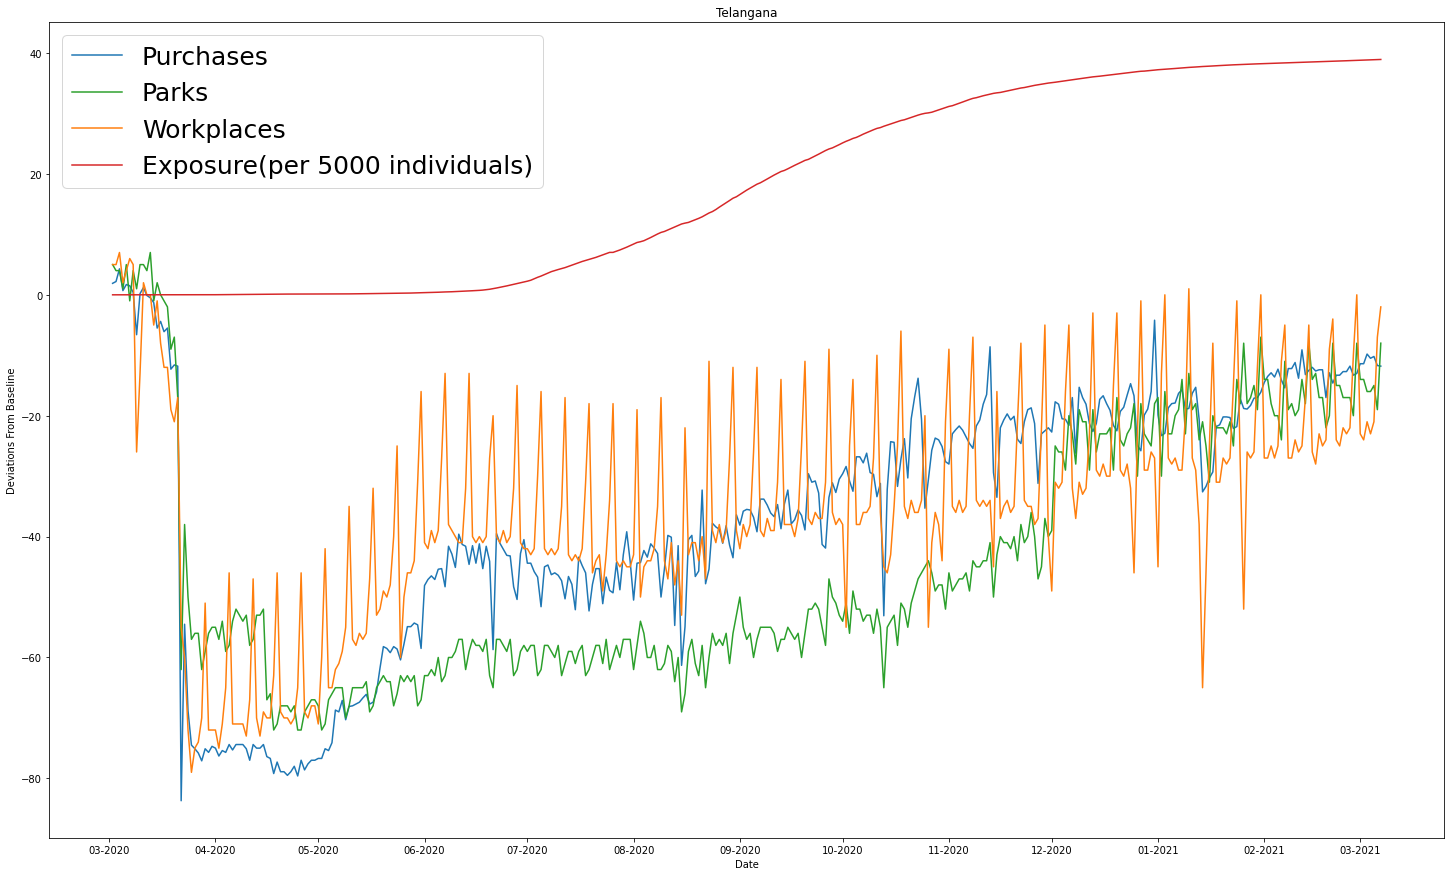

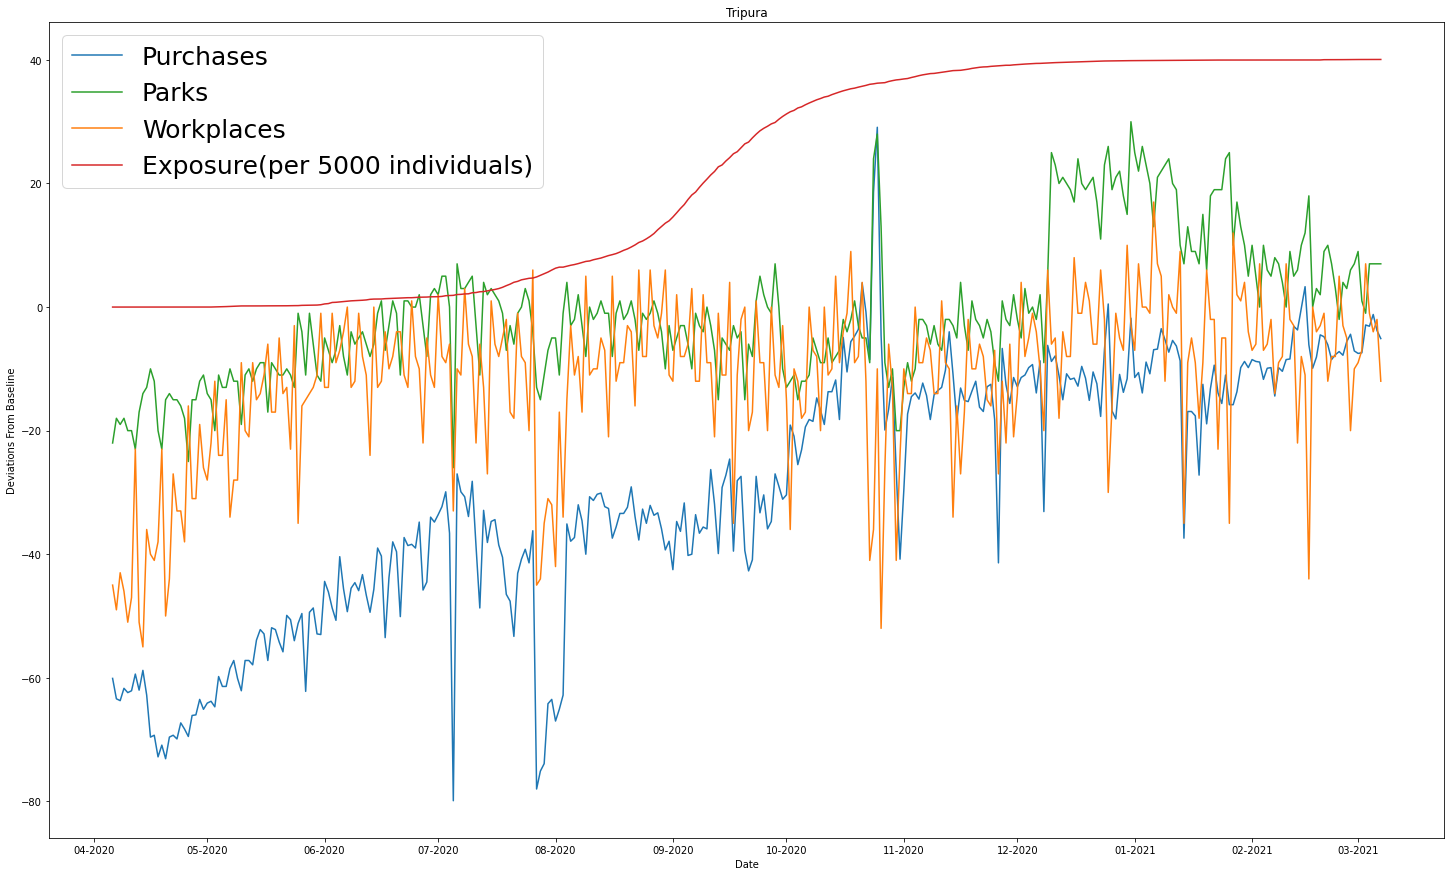

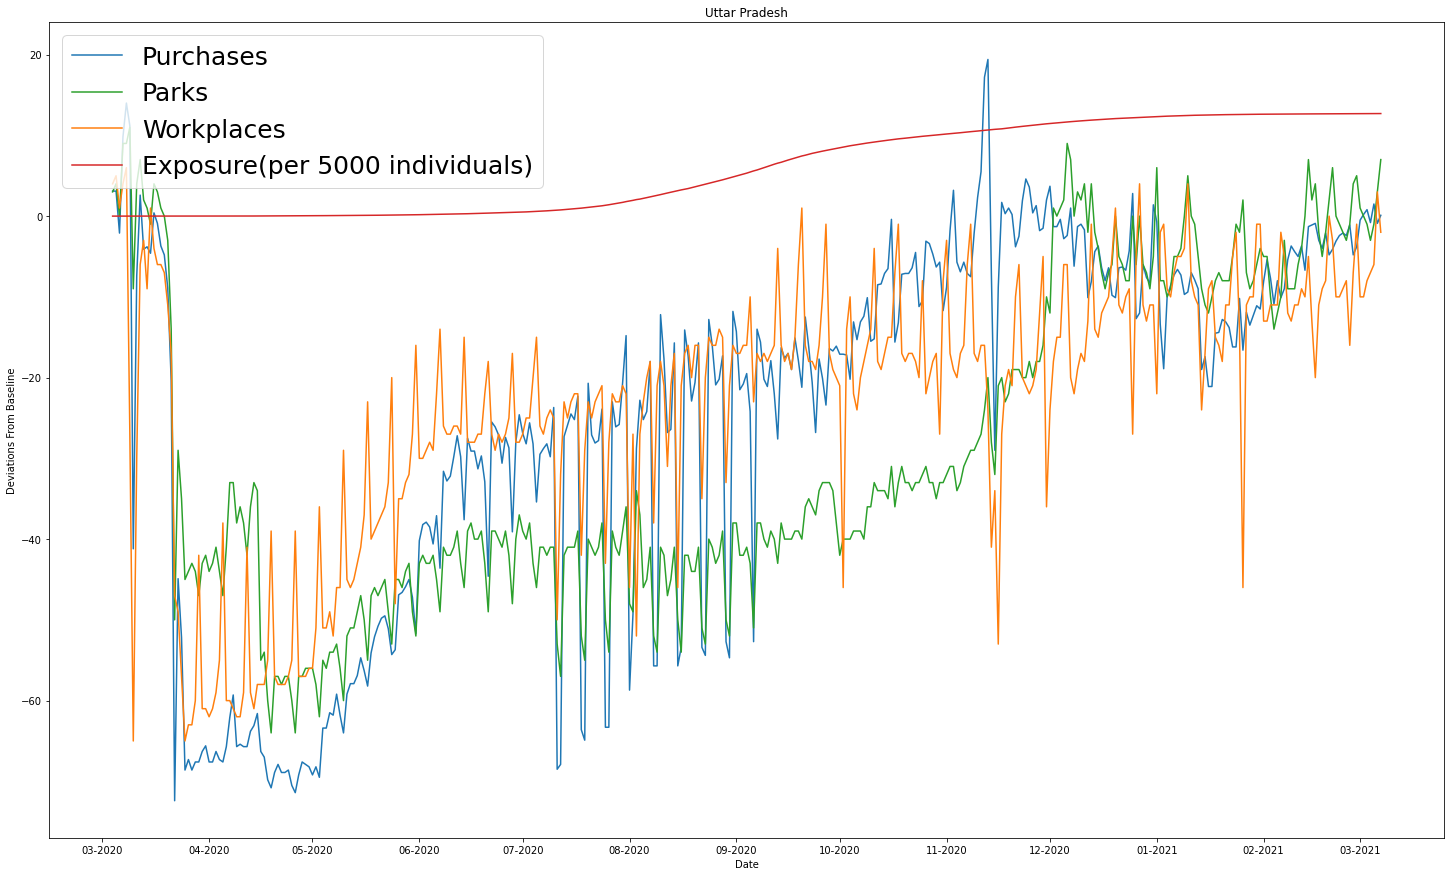

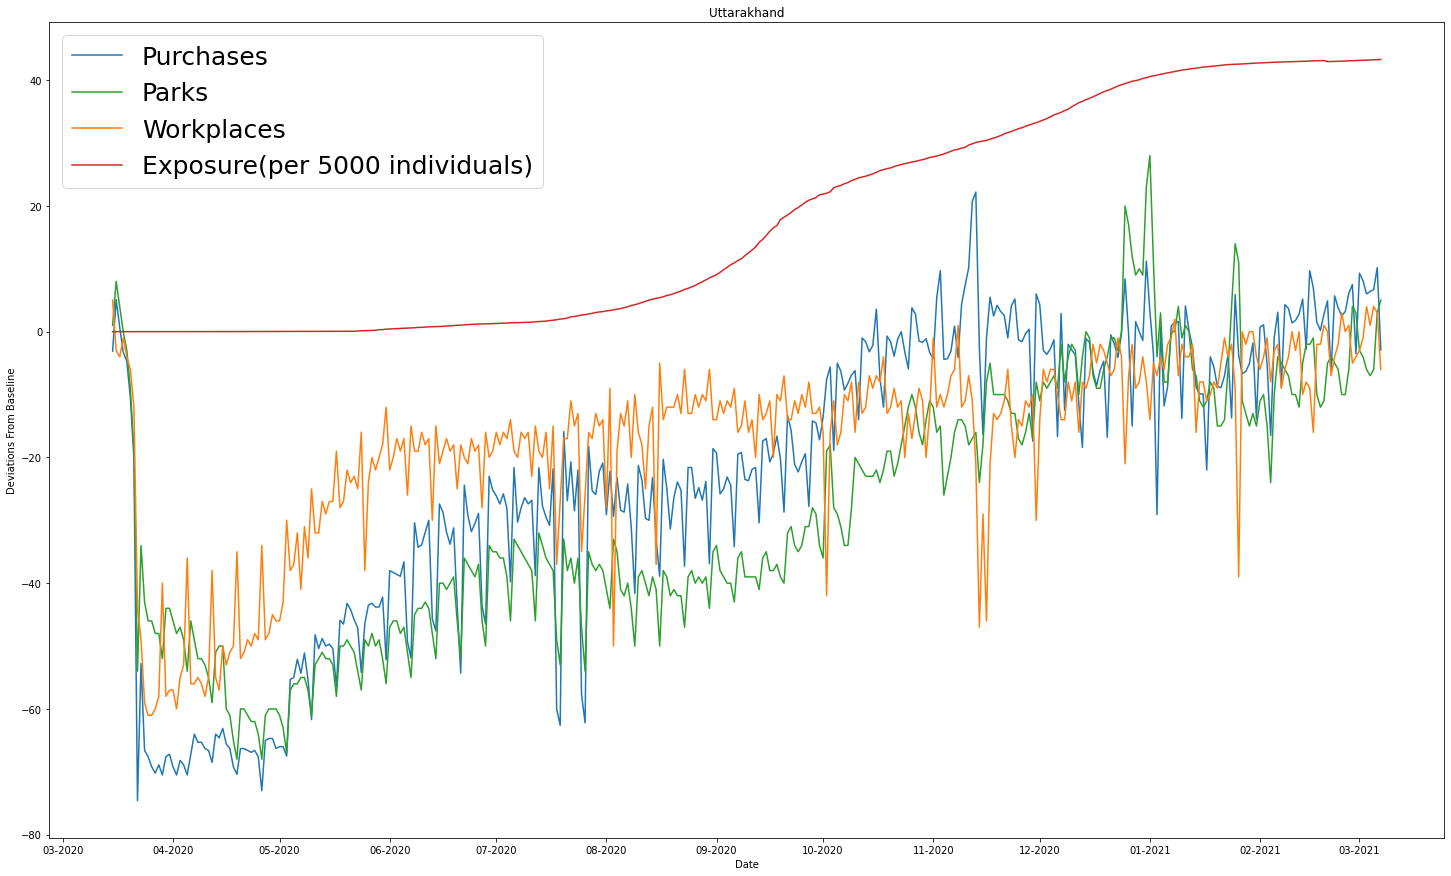

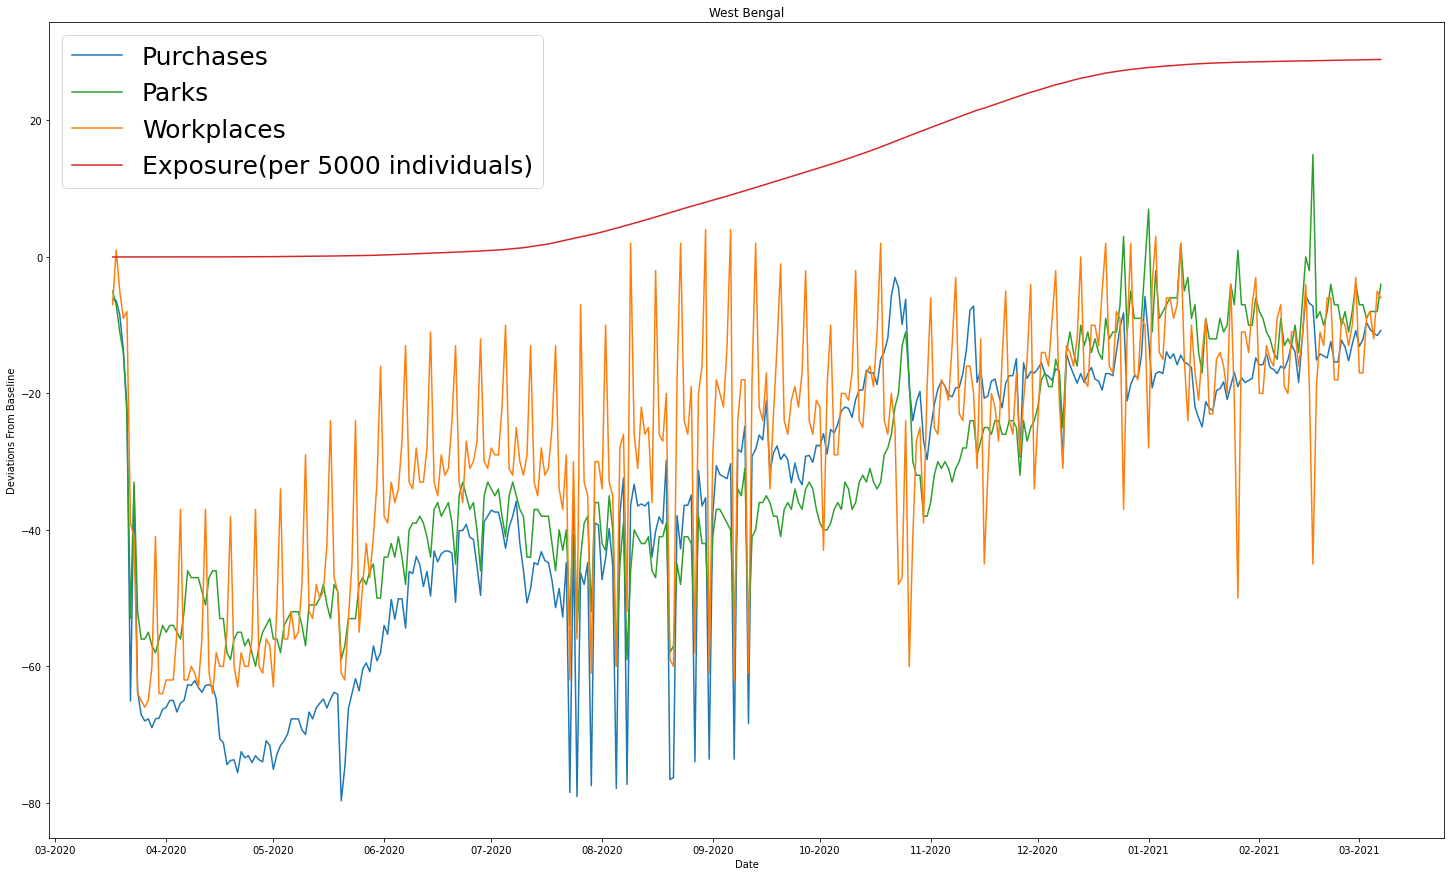

In [ ]:
for state_data in states:
    plot_state_data(state_data)